In [1]:
import random
from copy import deepcopy
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (15, 5)

# linestyles for graphics
line_styles = [
    'solid',
    'dotted',
    'dashdot',
]

# colors for graphics
line_colors = [
    'darkgreen',
    'firebrick',
    'gold',
    'hotpink',
    'darkviolet',
    'mediumblue'
]

In [2]:
sql_query_get_avg_min = """
    with avg_minimums as (
        select
            s.algorithm_name as name,
            s.iteration as iteration,
            avg(s.minimum) as avg_minimum
        from statistics s
        where s.experiment_name = NUMEXP
        group by
            s.algorithm_name, s.iteration
    )
    select * from avg_minimums
    where name like '%metric_NUMMETRIC'
    ;
    """

In [3]:
sql_query_get_avg_qualities = """
    with avg_qualities as (
        select
            q.algorithm_name as name,
            q.iteration as iteration,
            avg(quality) as avg_quality
        from qualities q
        where q.experiment_name = NUMEXP
        group by
            q.algorithm_name, q.iteration
    )
    select * from avg_qualities
    where name like '%metric_NUMMETRIC'
    ;
    """

In [4]:
sql_query_get_avg_invalid_inds = """
    with avg_invalid_ind as (
        select
            s.algorithm_name as name,
            s.iteration as iteration,
            avg(s.invalid_ind) as avg_invalid_ind
        from statistics s
        where s.experiment_name = NUMEXP
        group by
            s.algorithm_name, s.iteration
    )
    select * from avg_invalid_ind
    where name like '%metric_NUMMETRIC'
    ;
    """

In [5]:
sql_query_get_popular_regexes = """
    with popular_regex as (
        select
            output_regex as regex,
            count(*) as regex_count
        from experiments e
        where
            experiment_name = NUMEXP
            and algorithm_name like '%metric_NUMMETRIC'
        group by output_regex
    )
    select * from popular_regex
    order by regex_count desc
    ;
    """

In [6]:
import sqlite3

In [7]:
def get_data_from_db(num_exp, num_metric):
    db = sqlite3.connect('../coevolution.db')
    cursor = db.cursor()
    
    res = cursor.execute(
        sql_query_get_avg_min\
            .replace('NUMEXP', str(num_exp))\
            .replace('NUMMETRIC', str(num_metric))
    )
    minimum_metrics = res.fetchall()
    db.commit()

    res = cursor.execute(
        sql_query_get_avg_qualities\
            .replace('NUMEXP', str(num_exp))\
            .replace('NUMMETRIC', str(num_metric))
    )
    qualities_metrics = res.fetchall()
    db.commit()
    
    res = cursor.execute(
        sql_query_get_avg_invalid_inds\
            .replace('NUMEXP', str(num_exp))\
            .replace('NUMMETRIC', str(num_metric))
    )
    invalid_metrics = res.fetchall()
    db.commit()
    
    res = cursor.execute(
        sql_query_get_popular_regexes\
            .replace('NUMEXP', str(num_exp))\
            .replace('NUMMETRIC', str(num_metric))
    )
    popular_regexes = res.fetchall()
    db.commit()

    db.close()
    
    return minimum_metrics, qualities_metrics, invalid_metrics, popular_regexes

In [8]:
def get_qualities(qualities_metrics, exp_num=0, alg_num=0, ad_len=0):
    qualities_metrics = sorted(qualities_metrics)
    quality_dict = {}
    for metric in qualities_metrics:
        if 'sep' in metric[0]:
            continue
        if quality_dict.get(metric[0]):
            quality_dict[metric[0]].append(metric[2])
        else:
            quality_dict[metric[0]] = [metric[2]]
    
    for alg in quality_dict.keys():
        plt.plot(
            quality_dict[alg], 
            label=alg, 
            linestyle=random.choice(line_styles)
        )
        # TODO: Fix brute force
        plt.xticks(range(24))
        plt.yticks(range(10))
        plt.title(f'Качество итераций (эксперимент № {exp_num}, {alg_num} алгоритмов)')
        plt.xlabel('Итерации коэволюционного алгоритма')
        plt.ylabel('Качество итераций')
        _alg = alg
    
    plt.grid(linestyle='dashed', fillstyle='full', drawstyle='steps')
    
    plt.axvline(
        len(quality_dict[alg])-1, 
        c='darkviolet', 
        linestyle='dashed', 
        label='coevolution stop'
    )
    
    plt.legend(loc="best")
    
    plt.show()

In [9]:
import pandas as pd
import numpy as np

def ema(values):
    values = np.array(values)
    values = pd.DataFrame({'Values': values})
    return values.ewm(com=0.5).mean()


def get_invalids(invalid_metrics, exp_num=0):
    invalid_metrics = sorted(invalid_metrics)
    invalid_dict = {}
    for metric in invalid_metrics:
        if invalid_dict.get(metric[0]):
            invalid_dict[metric[0]].append(metric[2])
        else:
            invalid_dict[metric[0]] = [metric[2]]
    
    _line_colors = deepcopy(line_colors)
    _current_color = None
    _current_color_counter = 0
    
    for alg in invalid_dict.keys():
        
        if _current_color_counter == 2:
            _line_colors = _line_colors[1:]
            _current_color = None
            _current_color_counter = 0

        if _current_color is None:
            _current_color = _line_colors[0]

        if 'coev' in alg:
            linestyle = 'solid'
        else:
            linestyle = 'dashdot'
        
        plt.plot(
            ema(invalid_dict[alg]),
            label=alg,
            color=_current_color,
            linestyle=linestyle
        )
        plt.xticks(range(len(invalid_dict[alg])))
        plt.title(f'Ошибочные индивиды (эксперимент № {exp_num})')
        plt.legend(loc="best")
        plt.xlabel('Итерации алгоритмов')
        plt.ylabel('Ошибочные индивиды')
        
        _current_color_counter += 1
        
    plt.show()

/Users/nikitamoroskin/anaconda3/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [10]:
def get_minimums(minimum_metrics, adaptation_interval=0):
    minimum_metrics = sorted(minimum_metrics)
    minimum_dict = {}
    minimum_y = None
    maximum_y = None
    minimum_alg = None
    coev_len = 0
    for metric in minimum_metrics:
        
        if metric[1] == 1:
            continue
        
        if 'coev' in metric[0]:
            if metric[1] > coev_len:
                coev_len = metric[1]

        _minimum = metric[2]*1_000_000

        if minimum_dict.get(metric[0]):
            minimum_dict[metric[0]].append(_minimum)
        else:
            minimum_dict[metric[0]] = [_minimum]

        if minimum_y:
            if _minimum < minimum_y:
                minimum_alg = metric[0]
                minimum_y = _minimum
        else:
            minimum_alg = metric[0]
            minimum_y = _minimum
            
        if maximum_y:
            if _minimum > maximum_y:
                maximum_y = _minimum
        else:
            maximum_y = _minimum
    
    print(f'\nThe global minimum is: {minimum_y}')
    print(f'The global maximum is: {maximum_y}\n')
    
    _step = (maximum_y - minimum_y) / 100
    
    # calculate erorrs 1% and 5%
    for alg in minimum_dict.keys():
        _to_1 = 0
        _1_to_5 = 0
        _5_to = 0
        for metric in minimum_dict[alg]:
            if metric < minimum_y + _step:
                _to_1 += 1
            elif minimum_y + _step <= metric < minimum_y + (_step * 5):
                _1_to_5 += 1
            else:
                _5_to += 1
                
        print(f'Algorithm {alg}')
        print(f'\tValues best+1%: {_to_1}; {round(_to_1/len(minimum_dict[alg])*100)}% of population')
        print(f'\tValues between best+1% and best+5%: {_1_to_5}; {round(_1_to_5/len(minimum_dict[alg])*100)}% of population')
        print(f'\tValues greater than best+5%: {_5_to}; {round(_5_to/len(minimum_dict[alg])*100)}% of population')

    _line_colors = deepcopy(line_colors)
    _current_color = None
    _current_color_counter = 0
    max_len = 0

    for alg in minimum_dict.keys():
        
        if max_len < len(minimum_dict[alg]):
            max_len = len(minimum_dict[alg])
        
        if _current_color_counter == 2:
            _line_colors = _line_colors[1:]
            _current_color = None
            _current_color_counter = 0

        if _current_color is None:
            _current_color = _line_colors[0]

        if 'coev' in alg:
            linestyle = 'solid'
        else:
            linestyle = 'dashdot'
        plt.plot(
            minimum_dict[alg], 
            label=alg, 
            linestyle=linestyle,
            color=_current_color
        )
        plt.title('Минимумы')
        plt.xlabel(r"$итерация \quad алгоритма \quad i $")
        plt.ylabel(r"$минимум \quad индивида \quad Q \quad (5)$")

        _current_color_counter += 1

    plt.plot(
        list(range(max_len)), 
        [minimum_y] * max_len, 
        linestyle='dashed', 
        color='b', 
        label=f'minimum_{minimum_alg}'
    )
    
    plt.fill_between(
        list(range(max_len)), 
        [minimum_y] * max_len,
        [minimum_y + _step] * max_len,
        label=f'minimum_{minimum_alg} + 1%',
        alpha=0.3,
    )
    
    plt.fill_between(
        list(range(max_len)), 
        [minimum_y + _step] * max_len,
        [minimum_y + 5 * _step] * max_len,
        label=f'minimum_{minimum_alg} + 5%',
        alpha=0.5,
    )
    
    if adaptation_interval != 0:
        plt.axvline(
            adaptation_interval, 
            c='violet', 
            linestyle='dashed', 
            label='adaptation stop'
        )
        
    plt.axvline(
        coev_len-1, 
        c='black', 
        linestyle='dashed', 
        label='coevolution stop'
    )

    plt.legend(loc="best")
    plt.grid()
    plt.show()

In [11]:
def get_popular_regexes(popular_regexes):
    print('Популярность решений:')
    for regex in popular_regexes:
        if regex[1] != 1:
            print(f'--- {regex}')

## Metric №1 - Accuracy

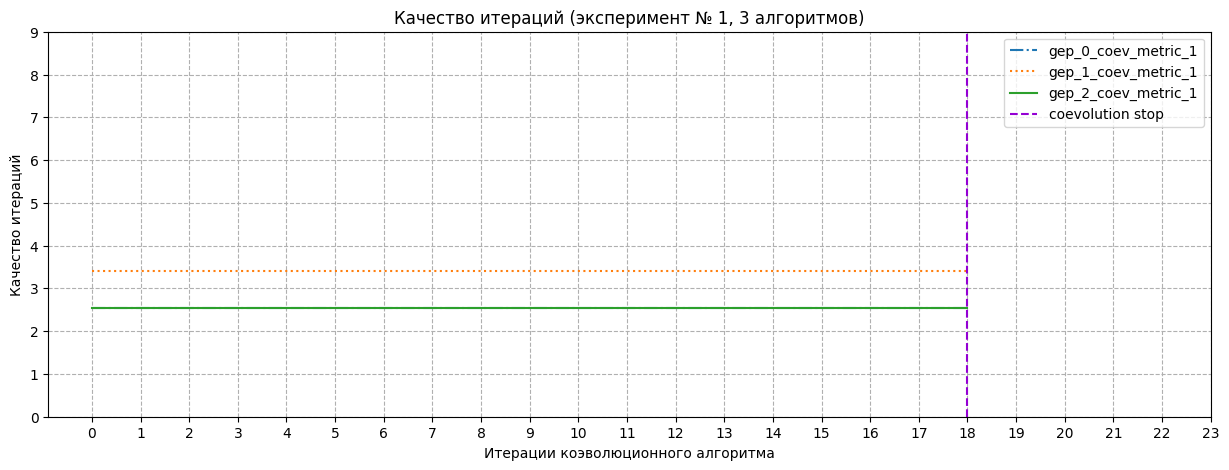

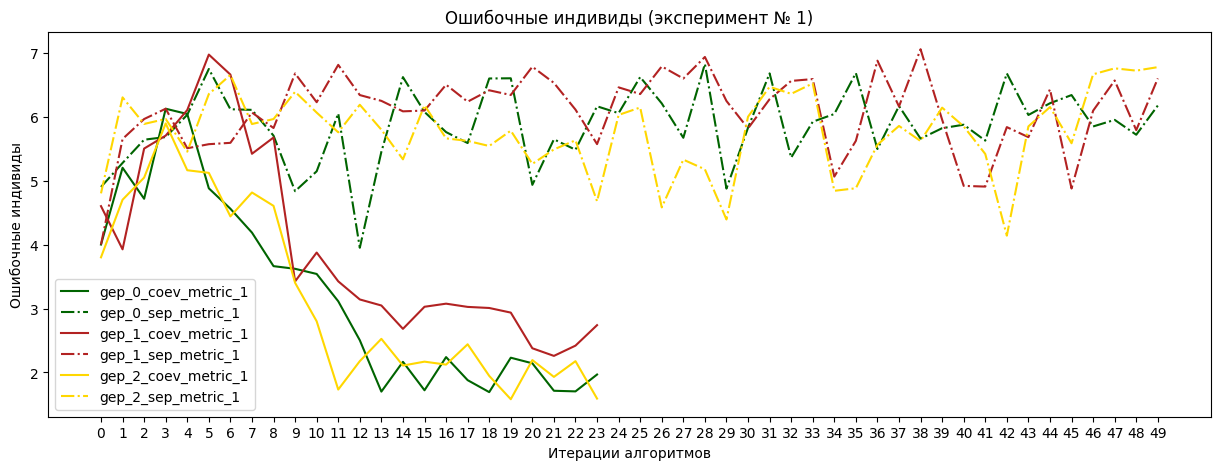


The global minimum is: 24.803602846461974
The global maximum is: 28.027428561472334

Algorithm gep_0_coev_metric_1
	Values best+1%: 0; 0% of population
	Values between best+1% and best+5%: 0; 0% of population
	Values greater than best+5%: 23; 100% of population
Algorithm gep_0_sep_metric_1
	Values best+1%: 0; 0% of population
	Values between best+1% and best+5%: 0; 0% of population
	Values greater than best+5%: 49; 100% of population
Algorithm gep_1_coev_metric_1
	Values best+1%: 0; 0% of population
	Values between best+1% and best+5%: 0; 0% of population
	Values greater than best+5%: 23; 100% of population
Algorithm gep_1_sep_metric_1
	Values best+1%: 6; 12% of population
	Values between best+1% and best+5%: 0; 0% of population
	Values greater than best+5%: 43; 88% of population
Algorithm gep_2_coev_metric_1
	Values best+1%: 0; 0% of population
	Values between best+1% and best+5%: 0; 0% of population
	Values greater than best+5%: 23; 100% of population
Algorithm gep_2_sep_metric_1
	V

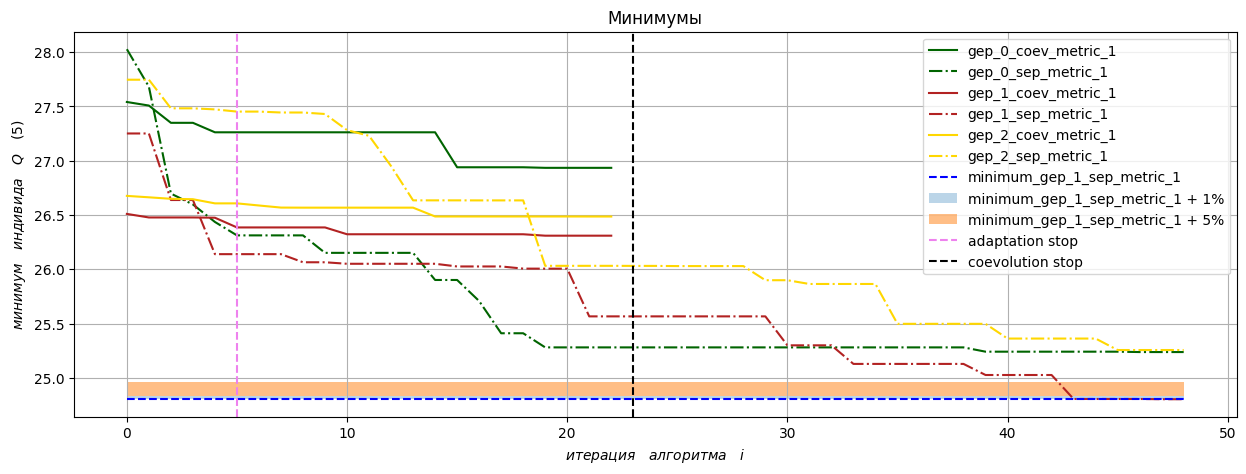

Популярность решений:
--- ('(...)', 6)
--- ('(dc.)', 3)
--- ('(abc)', 2)
--- ('(d..)', 2)


In [12]:
exp_num = 1
met_num = 1
alg_num = 3

minimum_metrics, qualities_metrics, invalid_metrics, popular_regexes = get_data_from_db(
    num_exp=exp_num, 
    num_metric=met_num
)

get_qualities(
    qualities_metrics, 
    exp_num=exp_num,
    alg_num=alg_num
)

get_invalids(
    invalid_metrics, 
    exp_num=exp_num
)

get_minimums(
    minimum_metrics, 
    adaptation_interval=5
)

get_popular_regexes(
    popular_regexes
)

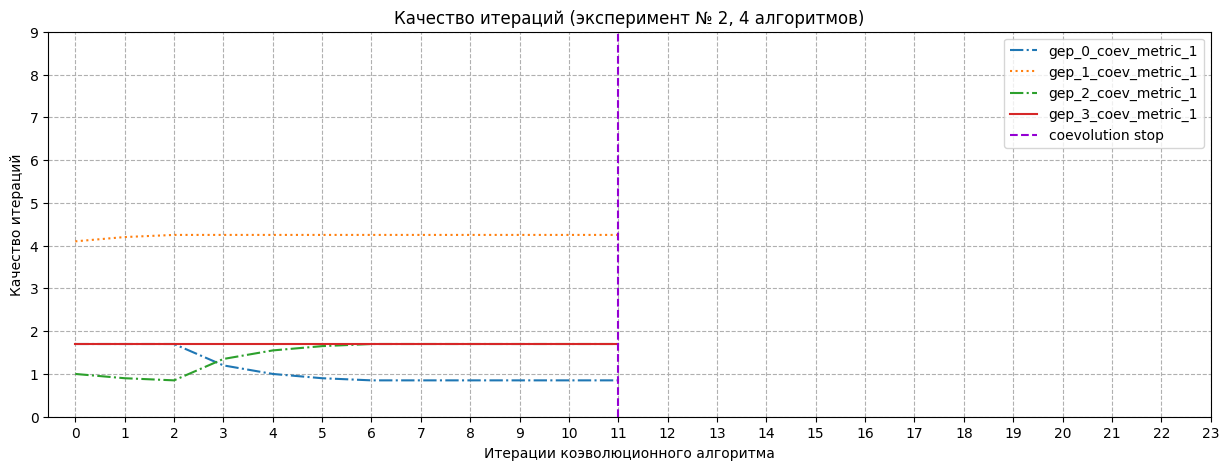

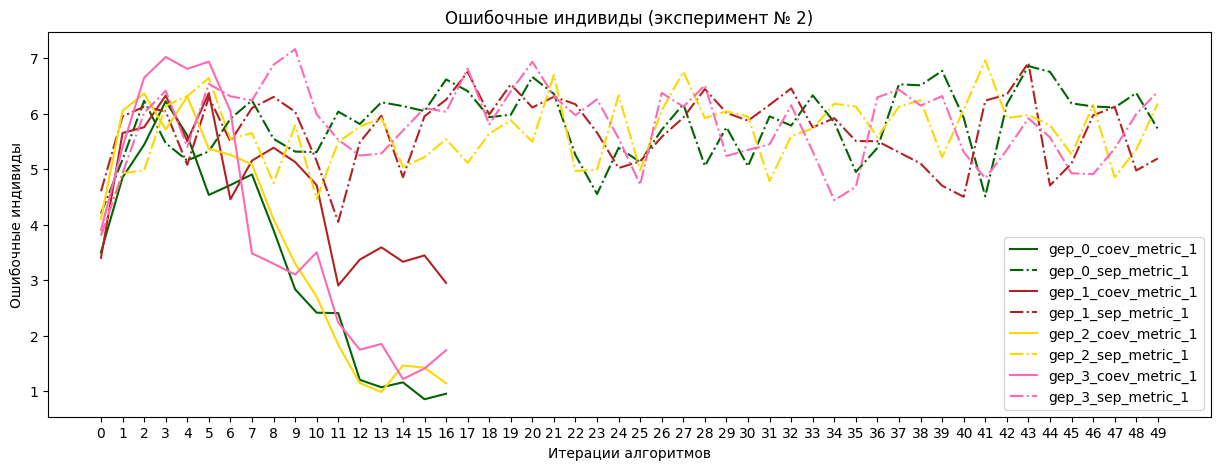


The global minimum is: 24.653918904928698
The global maximum is: 27.842450650826894

Algorithm gep_0_coev_metric_1
	Values best+1%: 0; 0% of population
	Values between best+1% and best+5%: 0; 0% of population
	Values greater than best+5%: 16; 100% of population
Algorithm gep_0_sep_metric_1
	Values best+1%: 0; 0% of population
	Values between best+1% and best+5%: 0; 0% of population
	Values greater than best+5%: 49; 100% of population
Algorithm gep_1_coev_metric_1
	Values best+1%: 0; 0% of population
	Values between best+1% and best+5%: 0; 0% of population
	Values greater than best+5%: 16; 100% of population
Algorithm gep_1_sep_metric_1
	Values best+1%: 5; 10% of population
	Values between best+1% and best+5%: 0; 0% of population
	Values greater than best+5%: 44; 90% of population
Algorithm gep_2_coev_metric_1
	Values best+1%: 0; 0% of population
	Values between best+1% and best+5%: 0; 0% of population
	Values greater than best+5%: 16; 100% of population
Algorithm gep_2_sep_metric_1
	V

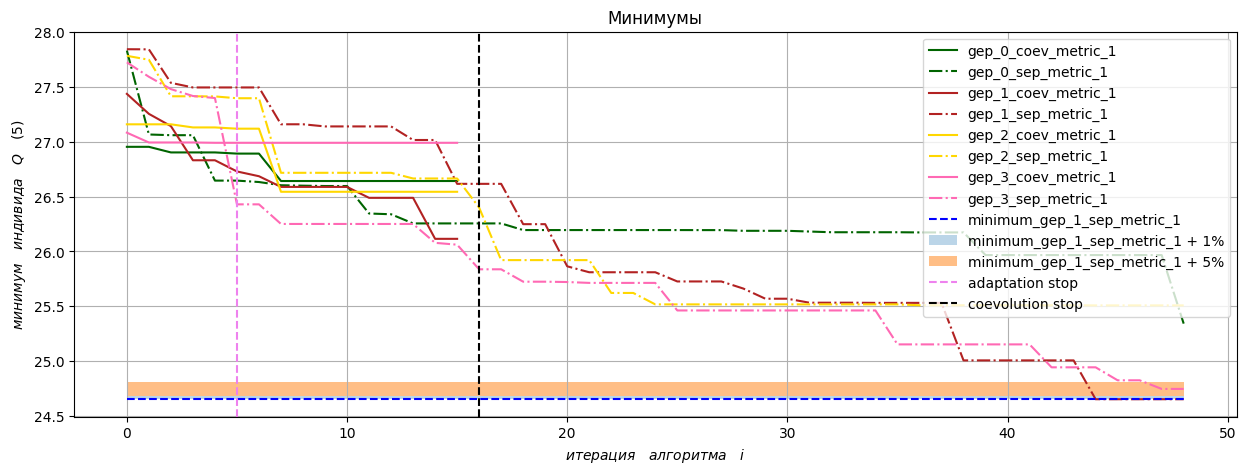

Популярность решений:
--- ('(...)', 5)
--- ('(d.b)', 3)
--- ('(dcb)', 3)
--- ('(.c.)', 2)


In [13]:
exp_num = 2
met_num = 1
alg_num = 4

minimum_metrics, qualities_metrics, invalid_metrics, popular_regexes = get_data_from_db(
    num_exp=exp_num, 
    num_metric=met_num
)

get_qualities(
    qualities_metrics, 
    exp_num=exp_num,
    alg_num=alg_num
)

get_invalids(
    invalid_metrics, 
    exp_num=exp_num
)

get_minimums(
    minimum_metrics, 
    adaptation_interval=5
)

get_popular_regexes(
    popular_regexes
)

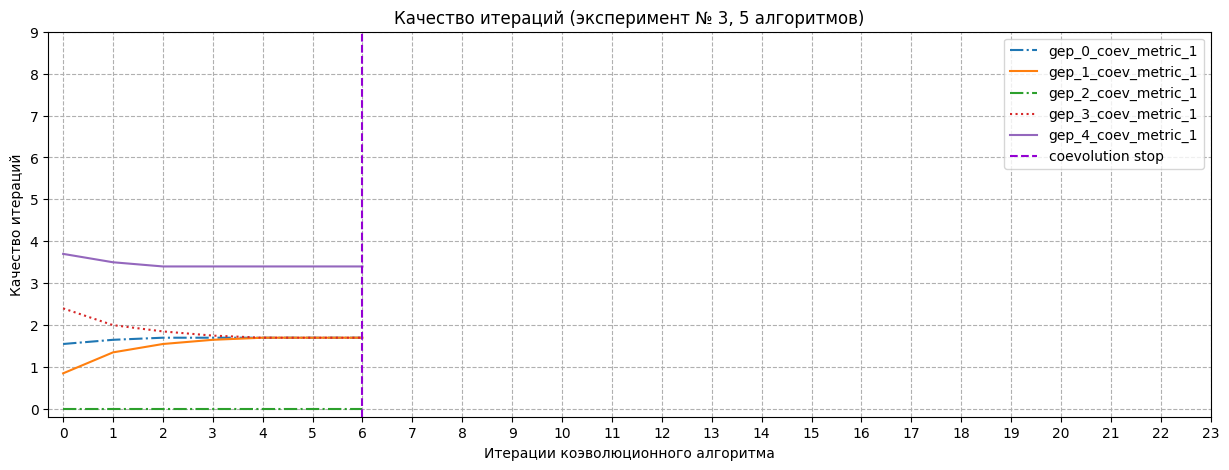

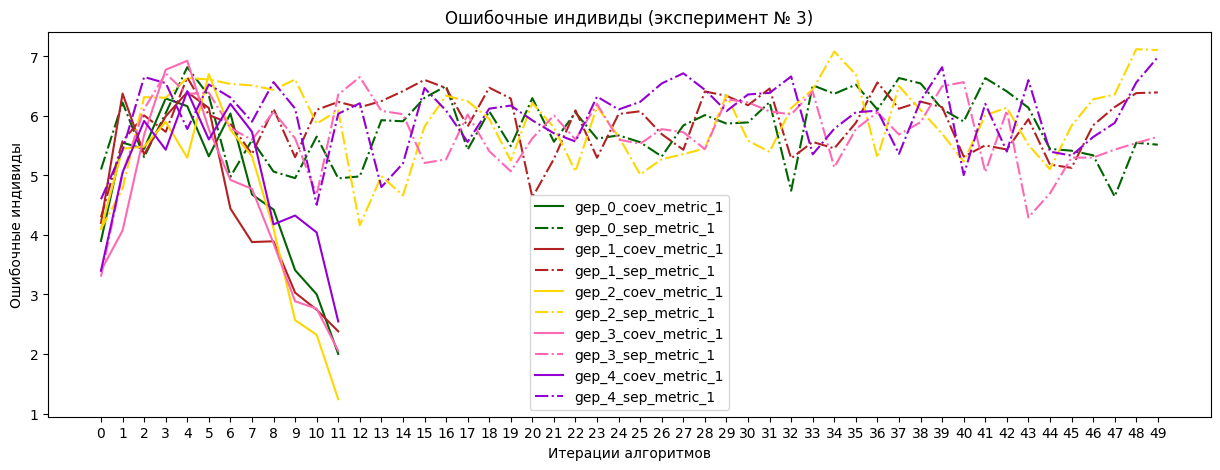


The global minimum is: 25.055999882737158
The global maximum is: 27.995362142974045

Algorithm gep_0_coev_metric_1
	Values best+1%: 0; 0% of population
	Values between best+1% and best+5%: 0; 0% of population
	Values greater than best+5%: 11; 100% of population
Algorithm gep_0_sep_metric_1
	Values best+1%: 2; 4% of population
	Values between best+1% and best+5%: 0; 0% of population
	Values greater than best+5%: 47; 96% of population
Algorithm gep_1_coev_metric_1
	Values best+1%: 0; 0% of population
	Values between best+1% and best+5%: 0; 0% of population
	Values greater than best+5%: 11; 100% of population
Algorithm gep_1_sep_metric_1
	Values best+1%: 0; 0% of population
	Values between best+1% and best+5%: 0; 0% of population
	Values greater than best+5%: 49; 100% of population
Algorithm gep_2_coev_metric_1
	Values best+1%: 0; 0% of population
	Values between best+1% and best+5%: 0; 0% of population
	Values greater than best+5%: 11; 100% of population
Algorithm gep_2_sep_metric_1
	Va

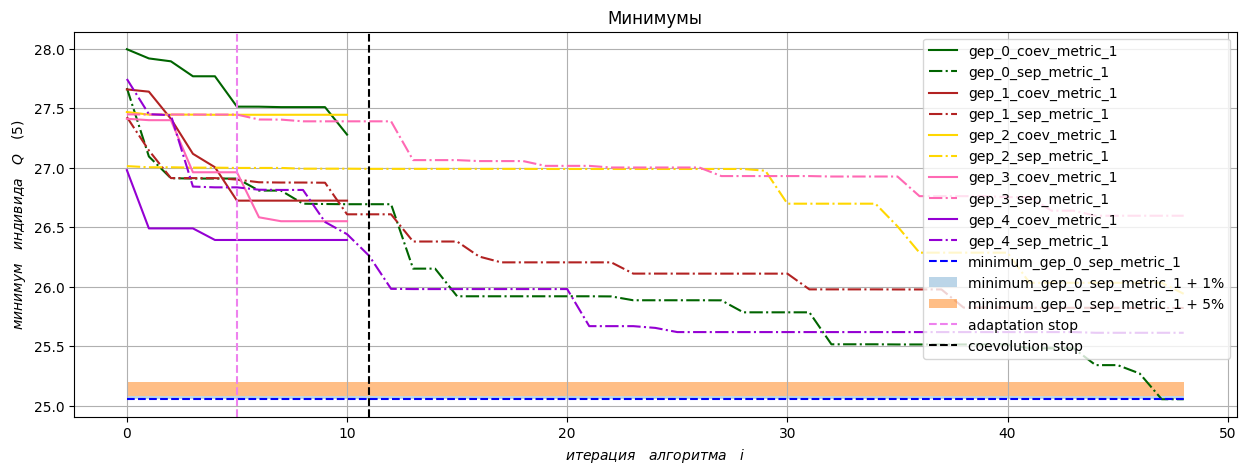

Популярность решений:
--- ('(..b)', 3)
--- ('(.c.)', 3)
--- ('(a.c)', 3)
--- ('(ab.)', 3)
--- ('(...)', 2)
--- ('(.bc)', 2)


In [14]:
exp_num = 3
met_num = 1
alg_num = 5

minimum_metrics, qualities_metrics, invalid_metrics, popular_regexes = get_data_from_db(
    num_exp=exp_num, 
    num_metric=met_num
)

get_qualities(
    qualities_metrics, 
    exp_num=exp_num,
    alg_num=alg_num
)

get_invalids(
    invalid_metrics, 
    exp_num=exp_num
)

get_minimums(
    minimum_metrics, 
    adaptation_interval=5
)

get_popular_regexes(
    popular_regexes
)

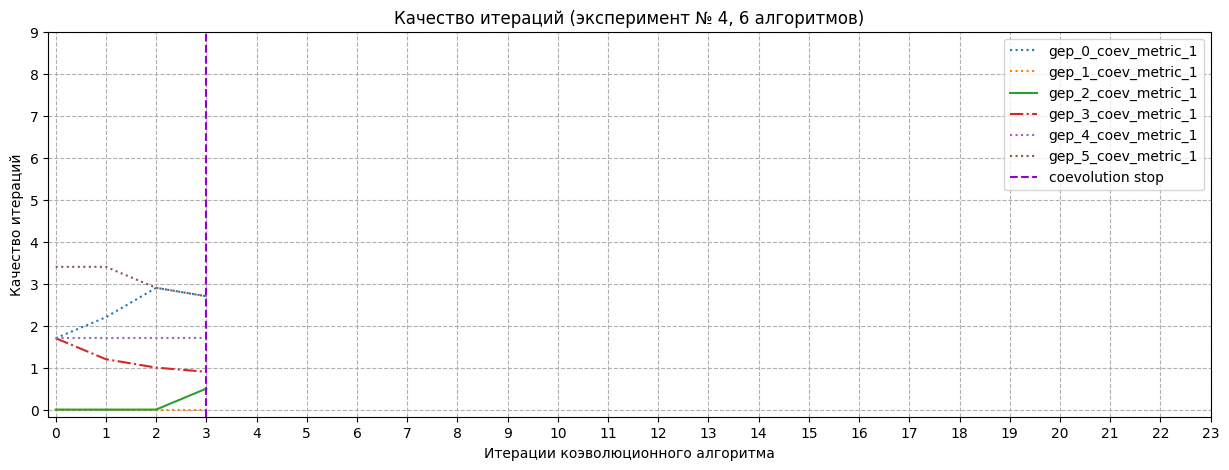

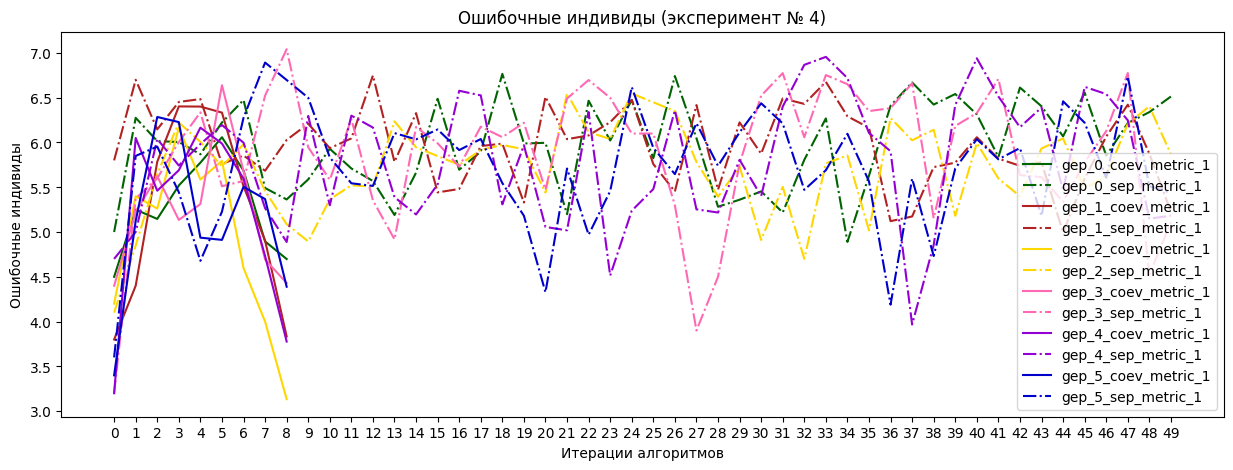


The global minimum is: 24.869594170667654
The global maximum is: 27.92162158584688

Algorithm gep_0_coev_metric_1
	Values best+1%: 0; 0% of population
	Values between best+1% and best+5%: 0; 0% of population
	Values greater than best+5%: 8; 100% of population
Algorithm gep_0_sep_metric_1
	Values best+1%: 0; 0% of population
	Values between best+1% and best+5%: 5; 10% of population
	Values greater than best+5%: 44; 90% of population
Algorithm gep_1_coev_metric_1
	Values best+1%: 0; 0% of population
	Values between best+1% and best+5%: 0; 0% of population
	Values greater than best+5%: 8; 100% of population
Algorithm gep_1_sep_metric_1
	Values best+1%: 0; 0% of population
	Values between best+1% and best+5%: 0; 0% of population
	Values greater than best+5%: 49; 100% of population
Algorithm gep_2_coev_metric_1
	Values best+1%: 0; 0% of population
	Values between best+1% and best+5%: 0; 0% of population
	Values greater than best+5%: 8; 100% of population
Algorithm gep_2_sep_metric_1
	Value

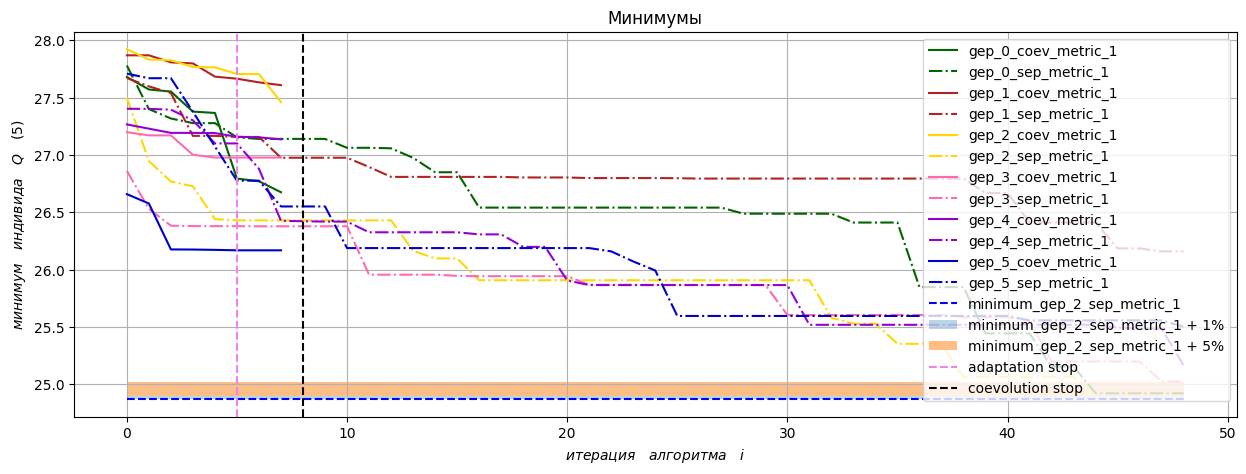

Популярность решений:
--- ('(.c.)', 6)
--- ('(a.c)', 6)
--- ('(...)', 4)
--- ('(.cb)', 3)
--- ('(a..)', 3)
--- ('(d.b)', 3)
--- ('((.)cb{0,1})', 2)
--- ('(..b)', 2)
--- ('(..c)', 2)
--- ('(abc)', 2)


In [15]:
exp_num = 4
met_num = 1
alg_num = 6

minimum_metrics, qualities_metrics, invalid_metrics, popular_regexes = get_data_from_db(
    num_exp=exp_num, 
    num_metric=met_num
)

get_qualities(
    qualities_metrics, 
    exp_num=exp_num,
    alg_num=alg_num
)

get_invalids(
    invalid_metrics, 
    exp_num=exp_num
)

get_minimums(
    minimum_metrics, 
    adaptation_interval=5
)

get_popular_regexes(
    popular_regexes
)

## Metric №2 - Precision

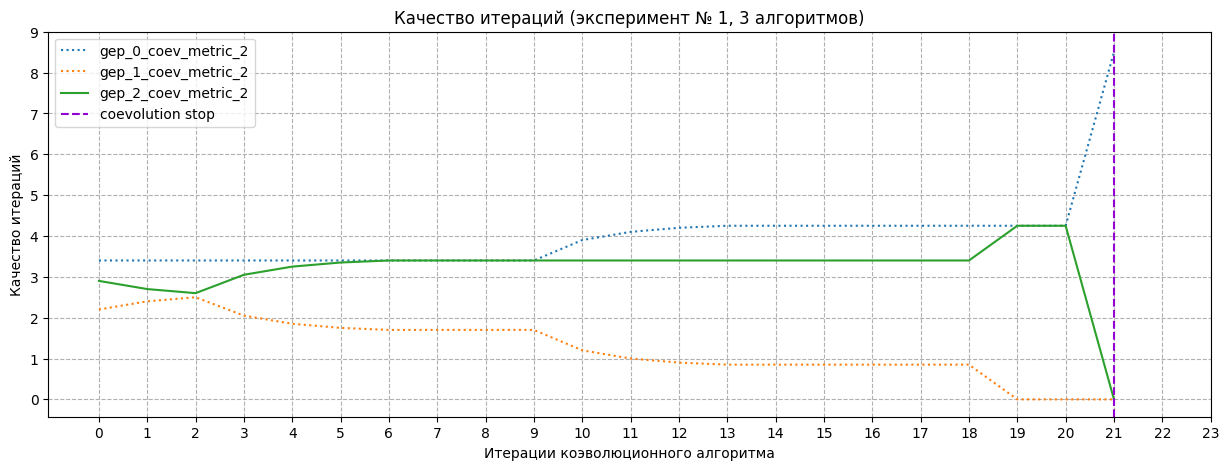

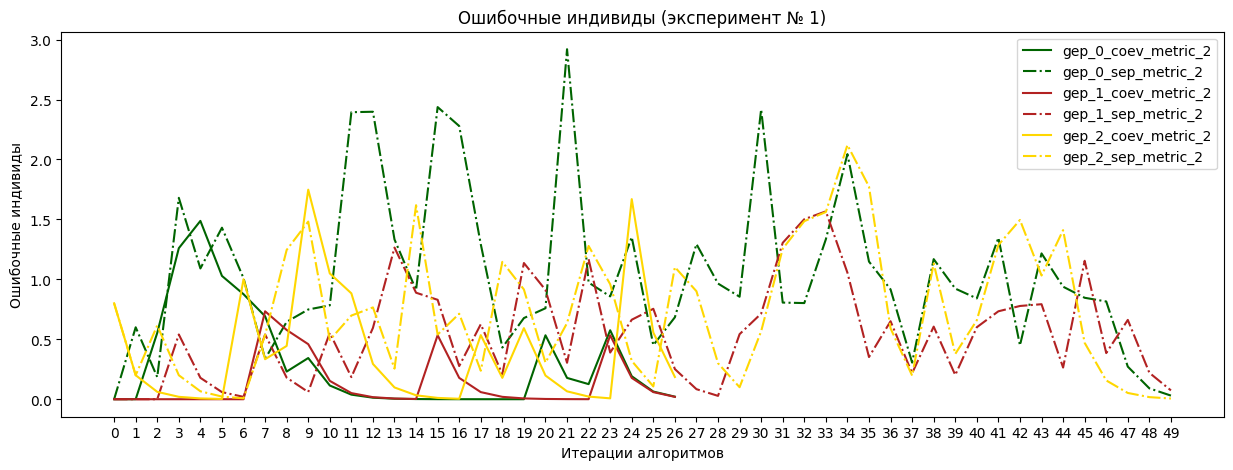


The global minimum is: 12.289711098260755
The global maximum is: 100000000000000.0

Algorithm gep_0_coev_metric_2
	Values best+1%: 1; 4% of population
	Values between best+1% and best+5%: 0; 0% of population
	Values greater than best+5%: 25; 96% of population
Algorithm gep_0_sep_metric_2
	Values best+1%: 5; 10% of population
	Values between best+1% and best+5%: 0; 0% of population
	Values greater than best+5%: 44; 90% of population
Algorithm gep_1_coev_metric_2
	Values best+1%: 3; 12% of population
	Values between best+1% and best+5%: 0; 0% of population
	Values greater than best+5%: 23; 88% of population
Algorithm gep_1_sep_metric_2
	Values best+1%: 0; 0% of population
	Values between best+1% and best+5%: 0; 0% of population
	Values greater than best+5%: 49; 100% of population
Algorithm gep_2_coev_metric_2
	Values best+1%: 3; 12% of population
	Values between best+1% and best+5%: 0; 0% of population
	Values greater than best+5%: 23; 88% of population
Algorithm gep_2_sep_metric_2
	Val

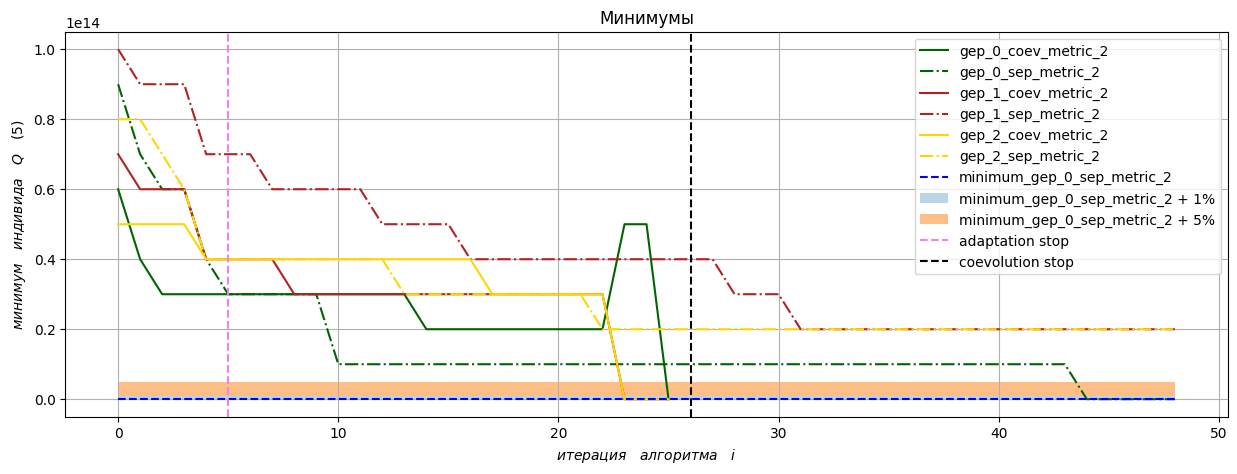

Популярность решений:
--- ('(.bc)', 4)
--- ('(a..)', 4)
--- ('(a.c)', 3)
--- ('(abc)', 3)
--- ('__error', 3)
--- ('(ab.)', 2)
--- ('(dc.)', 2)


In [16]:
exp_num = 1
met_num = 2
alg_num = 3

minimum_metrics, qualities_metrics, invalid_metrics, popular_regexes = get_data_from_db(
    num_exp=exp_num, 
    num_metric=met_num
)

get_qualities(
    qualities_metrics, 
    exp_num=exp_num,
    alg_num=alg_num
)

get_invalids(
    invalid_metrics, 
    exp_num=exp_num
)

get_minimums(
    minimum_metrics, 
    adaptation_interval=5
)

get_popular_regexes(
    popular_regexes
)

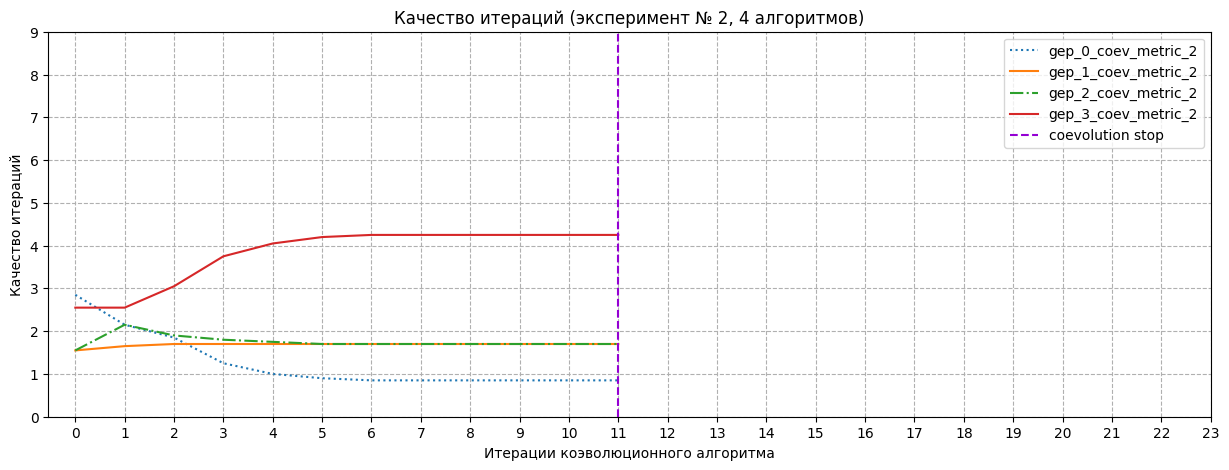

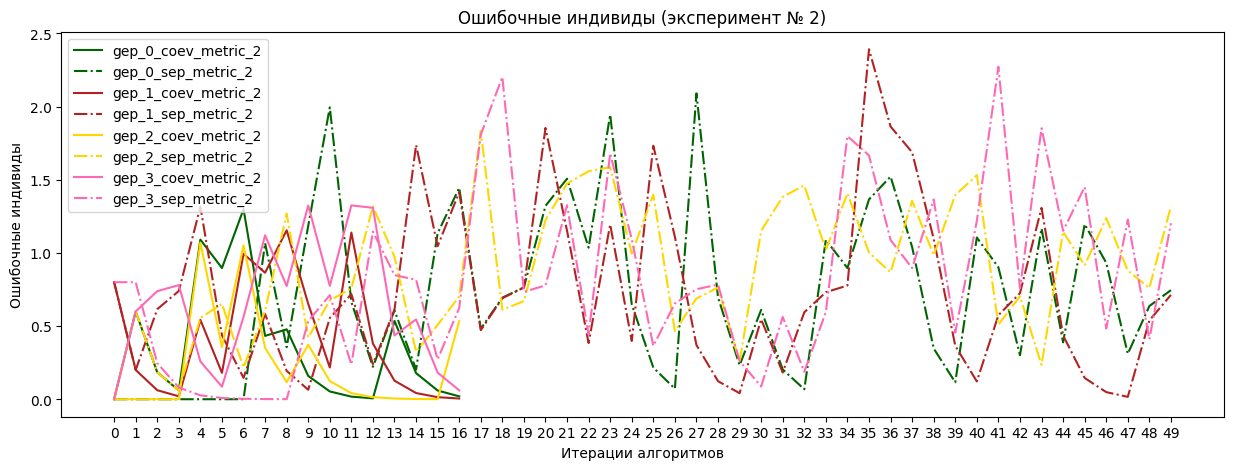


The global minimum is: 12.182844677061603
The global maximum is: 90000000000001.17

Algorithm gep_0_coev_metric_2
	Values best+1%: 0; 0% of population
	Values between best+1% and best+5%: 0; 0% of population
	Values greater than best+5%: 16; 100% of population
Algorithm gep_0_sep_metric_2
	Values best+1%: 0; 0% of population
	Values between best+1% and best+5%: 0; 0% of population
	Values greater than best+5%: 49; 100% of population
Algorithm gep_1_coev_metric_2
	Values best+1%: 0; 0% of population
	Values between best+1% and best+5%: 0; 0% of population
	Values greater than best+5%: 16; 100% of population
Algorithm gep_1_sep_metric_2
	Values best+1%: 0; 0% of population
	Values between best+1% and best+5%: 0; 0% of population
	Values greater than best+5%: 49; 100% of population
Algorithm gep_2_coev_metric_2
	Values best+1%: 0; 0% of population
	Values between best+1% and best+5%: 0; 0% of population
	Values greater than best+5%: 16; 100% of population
Algorithm gep_2_sep_metric_2
	Va

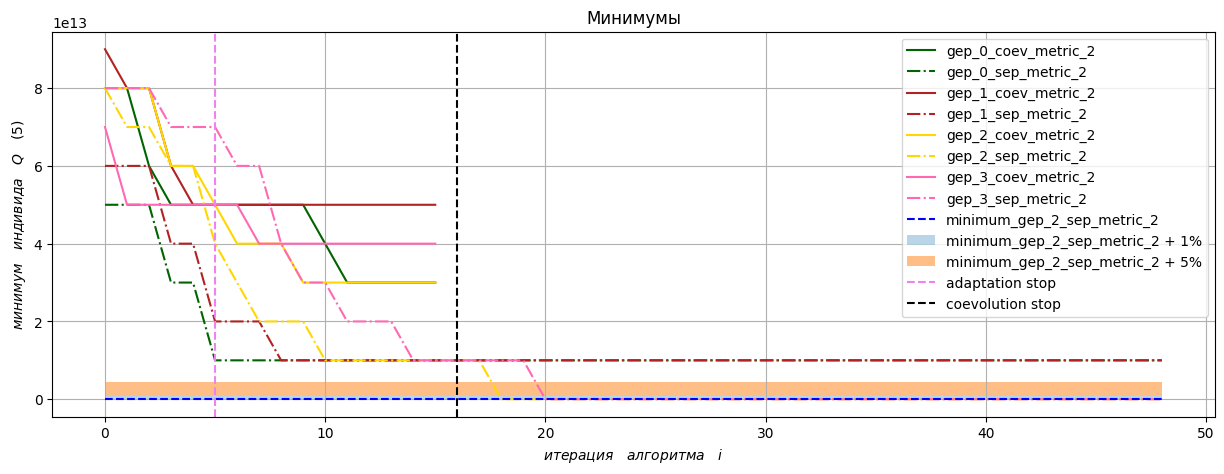

Популярность решений:
--- ('(ab.)', 5)
--- ('(a.c)', 4)
--- ('(..c)', 3)
--- ('(.b.)', 3)
--- ('(.bc)', 3)
--- ('(a..)', 3)
--- ('(d.b)', 3)
--- ('(dcb)', 3)
--- ('(..b)', 2)
--- ('(dc.)', 2)
--- ('__error', 2)


In [17]:
exp_num = 2
met_num = 2
alg_num = 4

minimum_metrics, qualities_metrics, invalid_metrics, popular_regexes = get_data_from_db(
    num_exp=exp_num, 
    num_metric=met_num
)

get_qualities(
    qualities_metrics, 
    exp_num=exp_num,
    alg_num=alg_num
)

get_invalids(
    invalid_metrics, 
    exp_num=exp_num
)

get_minimums(
    minimum_metrics, 
    adaptation_interval=5
)

get_popular_regexes(
    popular_regexes
)

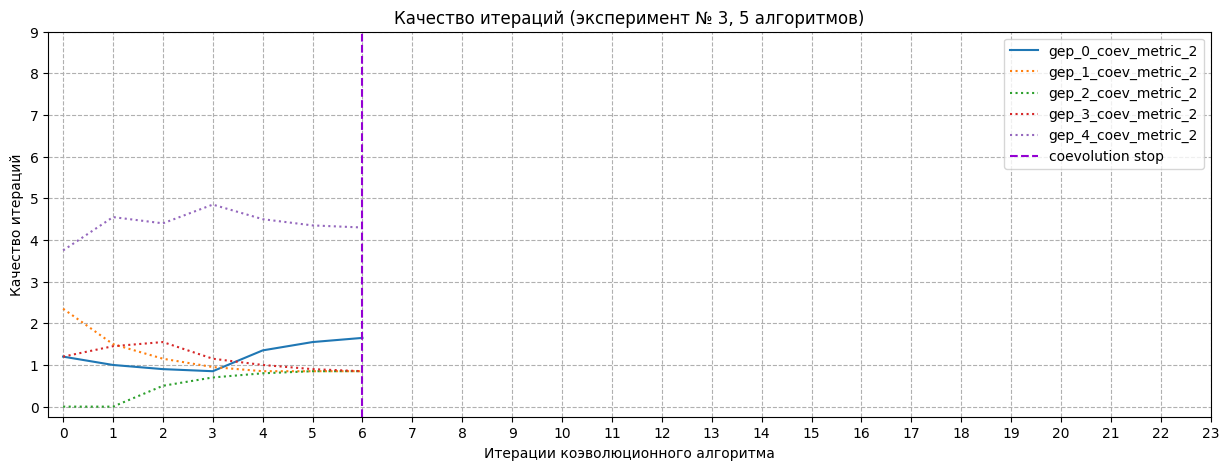

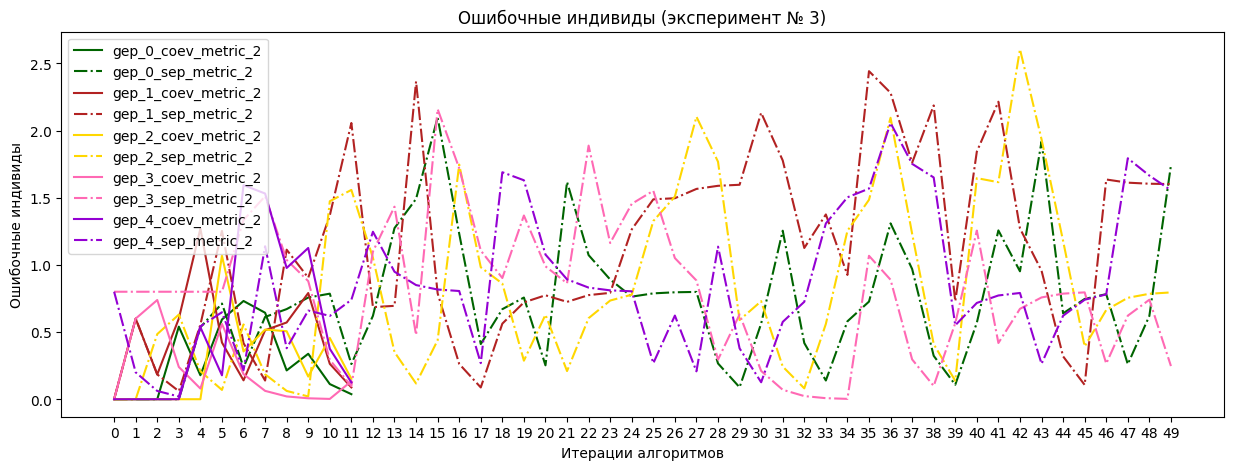


The global minimum is: 12.18271572724916
The global maximum is: 90000000000001.72

Algorithm gep_0_coev_metric_2
	Values best+1%: 0; 0% of population
	Values between best+1% and best+5%: 0; 0% of population
	Values greater than best+5%: 11; 100% of population
Algorithm gep_0_sep_metric_2
	Values best+1%: 25; 51% of population
	Values between best+1% and best+5%: 0; 0% of population
	Values greater than best+5%: 24; 49% of population
Algorithm gep_1_coev_metric_2
	Values best+1%: 0; 0% of population
	Values between best+1% and best+5%: 0; 0% of population
	Values greater than best+5%: 11; 100% of population
Algorithm gep_1_sep_metric_2
	Values best+1%: 29; 59% of population
	Values between best+1% and best+5%: 0; 0% of population
	Values greater than best+5%: 20; 41% of population
Algorithm gep_2_coev_metric_2
	Values best+1%: 0; 0% of population
	Values between best+1% and best+5%: 0; 0% of population
	Values greater than best+5%: 11; 100% of population
Algorithm gep_2_sep_metric_2
	V

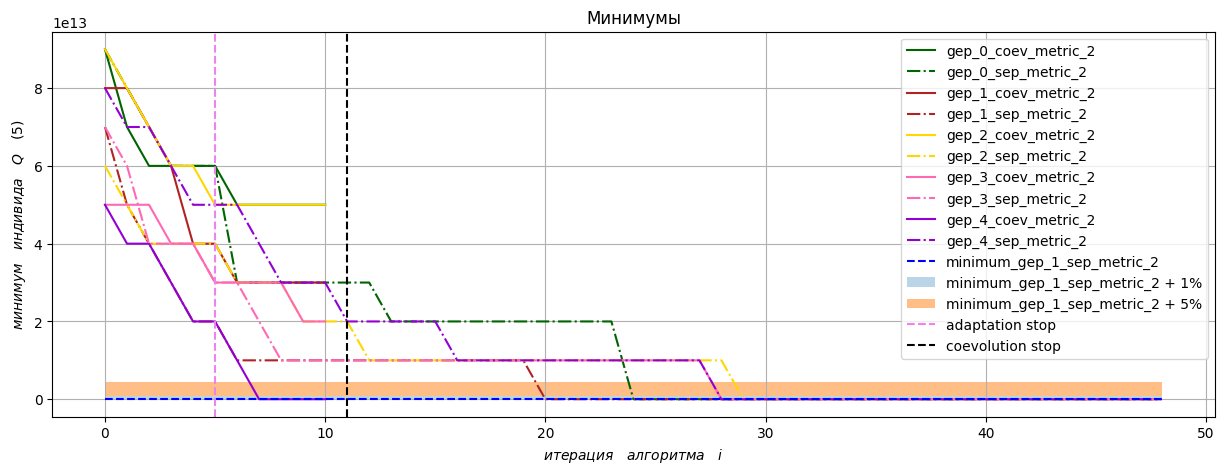

Популярность решений:
--- ('(.bc)', 6)
--- ('(abc)', 6)
--- ('(a..)', 4)
--- ('(dcb)', 4)
--- ('(..b)', 3)
--- ('(ab.)', 3)
--- ('(..c)', 2)
--- ('(.b.)', 2)
--- ('(.cb)', 2)
--- ('(a(.|b)c)', 2)
--- ('(a.c)', 2)
--- ('(dc.)', 2)


In [18]:
exp_num = 3
met_num = 2
alg_num = 5

minimum_metrics, qualities_metrics, invalid_metrics, popular_regexes = get_data_from_db(
    num_exp=exp_num, 
    num_metric=met_num
)

get_qualities(
    qualities_metrics, 
    exp_num=exp_num,
    alg_num=alg_num
)

get_invalids(
    invalid_metrics, 
    exp_num=exp_num
)

get_minimums(
    minimum_metrics, 
    adaptation_interval=5
)

get_popular_regexes(
    popular_regexes
)

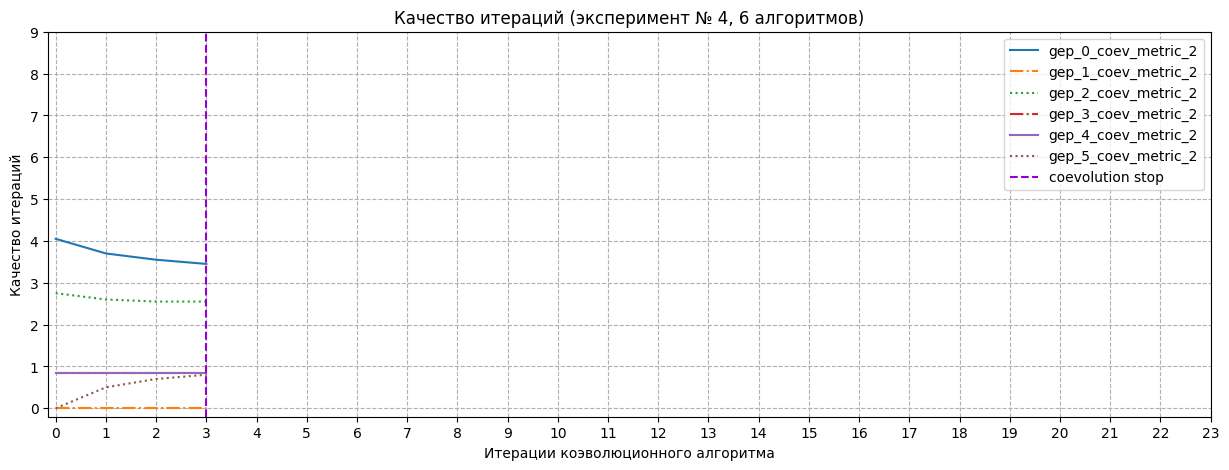

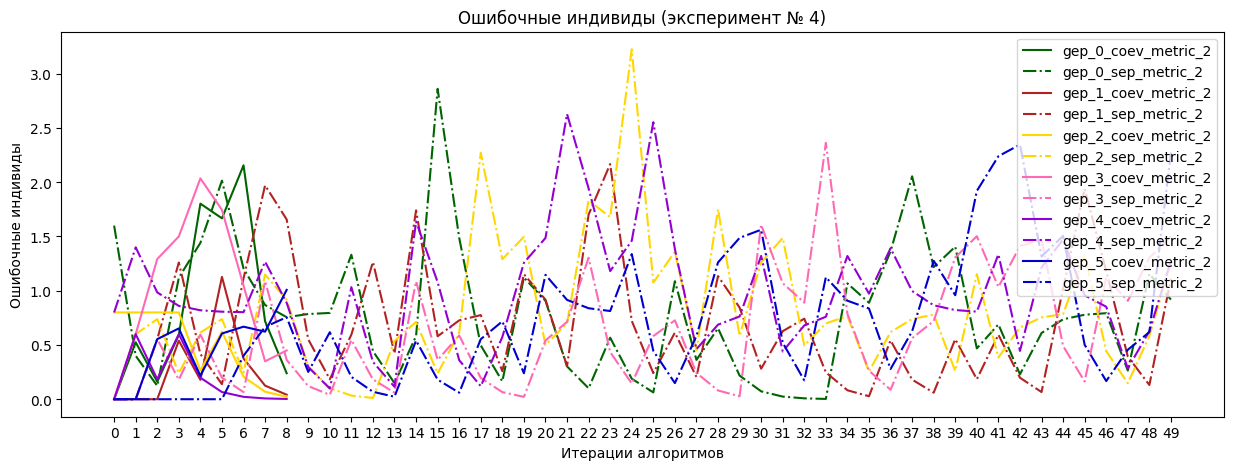


The global minimum is: 12.231368765986355
The global maximum is: 80000000000002.81

Algorithm gep_0_coev_metric_2
	Values best+1%: 0; 0% of population
	Values between best+1% and best+5%: 0; 0% of population
	Values greater than best+5%: 8; 100% of population
Algorithm gep_0_sep_metric_2
	Values best+1%: 23; 47% of population
	Values between best+1% and best+5%: 0; 0% of population
	Values greater than best+5%: 26; 53% of population
Algorithm gep_1_coev_metric_2
	Values best+1%: 0; 0% of population
	Values between best+1% and best+5%: 0; 0% of population
	Values greater than best+5%: 8; 100% of population
Algorithm gep_1_sep_metric_2
	Values best+1%: 41; 84% of population
	Values between best+1% and best+5%: 0; 0% of population
	Values greater than best+5%: 8; 16% of population
Algorithm gep_2_coev_metric_2
	Values best+1%: 0; 0% of population
	Values between best+1% and best+5%: 0; 0% of population
	Values greater than best+5%: 8; 100% of population
Algorithm gep_2_sep_metric_2
	Valu

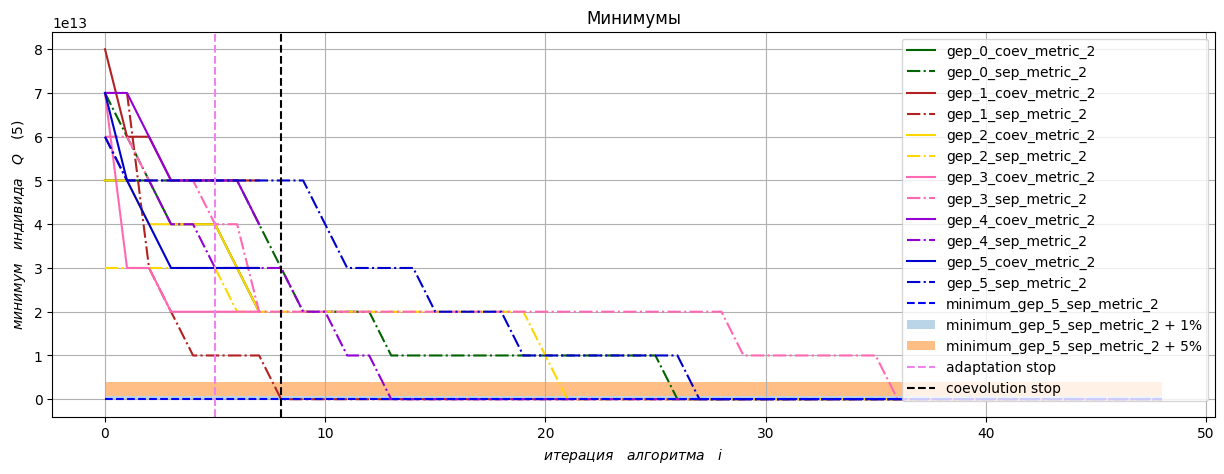

Популярность решений:
--- ('(dcb)', 8)
--- ('(.bc)', 7)
--- ('(d.b)', 7)
--- ('(abc)', 5)
--- ('(..c)', 4)
--- ('(a..)', 4)
--- ('(a.c)', 4)
--- ('(..b)', 3)
--- ('(.b.)', 2)
--- ('(ab.)', 2)
--- ('(dc.)', 2)


In [19]:
exp_num = 4
met_num = 2
alg_num = 6

minimum_metrics, qualities_metrics, invalid_metrics, popular_regexes = get_data_from_db(
    num_exp=exp_num, 
    num_metric=met_num
)

get_qualities(
    qualities_metrics, 
    exp_num=exp_num,
    alg_num=alg_num
)

get_invalids(
    invalid_metrics, 
    exp_num=exp_num
)

get_minimums(
    minimum_metrics, 
    adaptation_interval=5
)

get_popular_regexes(
    popular_regexes
)

## Metric №3 - Recall

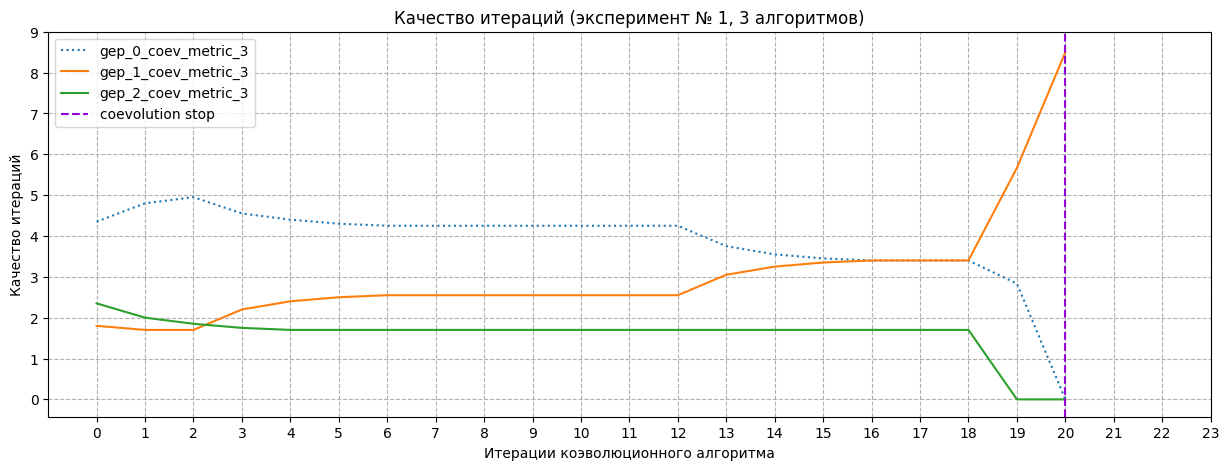

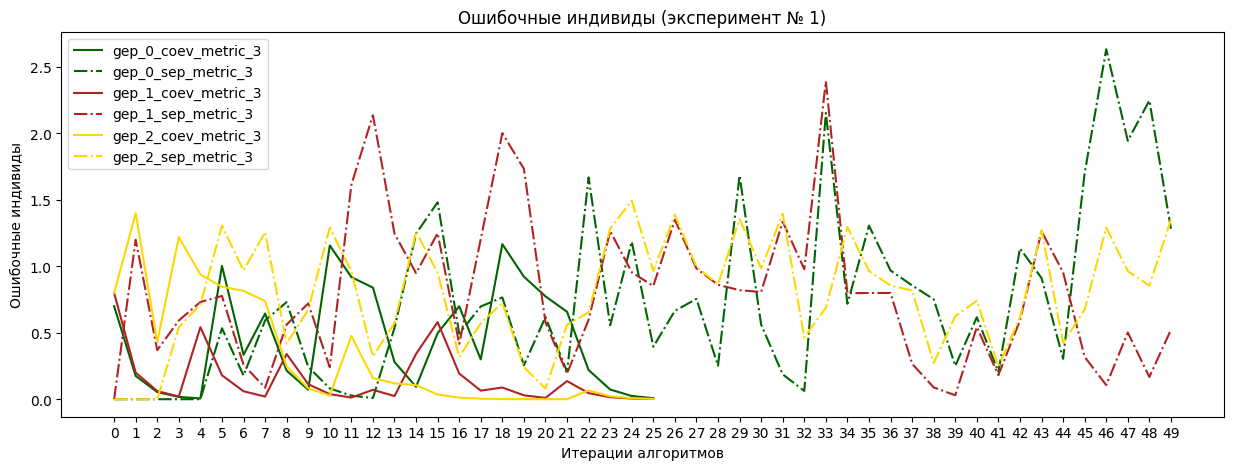


The global minimum is: 47.78762084240374
The global maximum is: 100000000000000.0

Algorithm gep_0_coev_metric_3
	Values best+1%: 7; 28% of population
	Values between best+1% and best+5%: 0; 0% of population
	Values greater than best+5%: 18; 72% of population
Algorithm gep_0_sep_metric_3
	Values best+1%: 32; 65% of population
	Values between best+1% and best+5%: 0; 0% of population
	Values greater than best+5%: 17; 35% of population
Algorithm gep_1_coev_metric_3
	Values best+1%: 2; 8% of population
	Values between best+1% and best+5%: 0; 0% of population
	Values greater than best+5%: 23; 92% of population
Algorithm gep_1_sep_metric_3
	Values best+1%: 8; 16% of population
	Values between best+1% and best+5%: 0; 0% of population
	Values greater than best+5%: 41; 84% of population
Algorithm gep_2_coev_metric_3
	Values best+1%: 0; 0% of population
	Values between best+1% and best+5%: 0; 0% of population
	Values greater than best+5%: 25; 100% of population
Algorithm gep_2_sep_metric_3
	Val

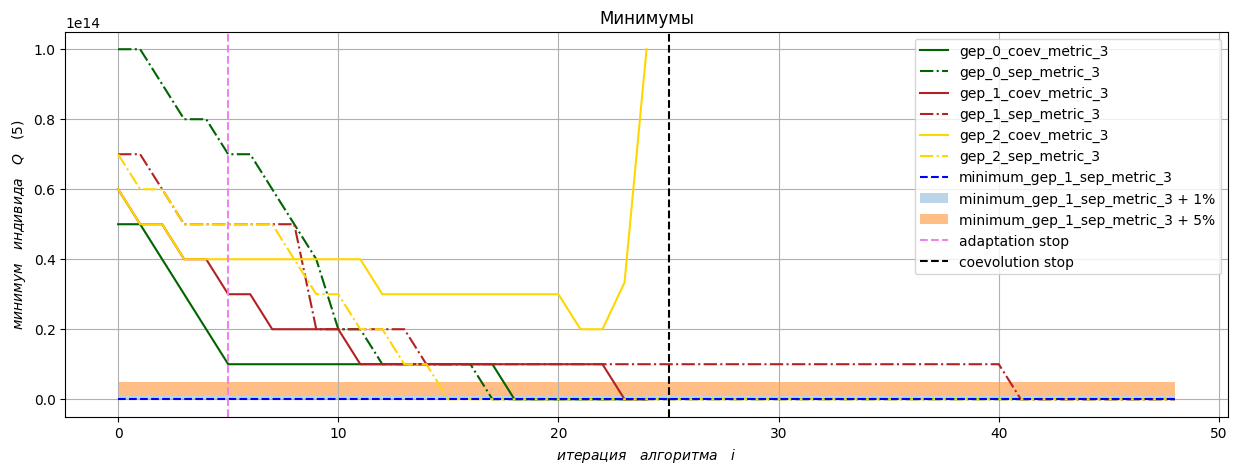

Популярность решений:
--- ('((.)..{0,1})', 3)
--- ('((.).{0,1}.)', 3)
--- ('(...)', 3)
--- ('(a.c)', 3)
--- ('(d.b)', 3)
--- ('((.).{0,1}.{0,1})', 2)
--- ('(.cb)', 2)
--- ('(abc)', 2)
--- ('(dcb)', 2)


In [20]:
exp_num = 1
met_num = 3
alg_num = 3

minimum_metrics, qualities_metrics, invalid_metrics, popular_regexes = get_data_from_db(
    num_exp=exp_num, 
    num_metric=met_num
)

get_qualities(
    qualities_metrics, 
    exp_num=exp_num,
    alg_num=alg_num
)

get_invalids(
    invalid_metrics, 
    exp_num=exp_num
)

get_minimums(
    minimum_metrics, 
    adaptation_interval=5
)

get_popular_regexes(
    popular_regexes
)

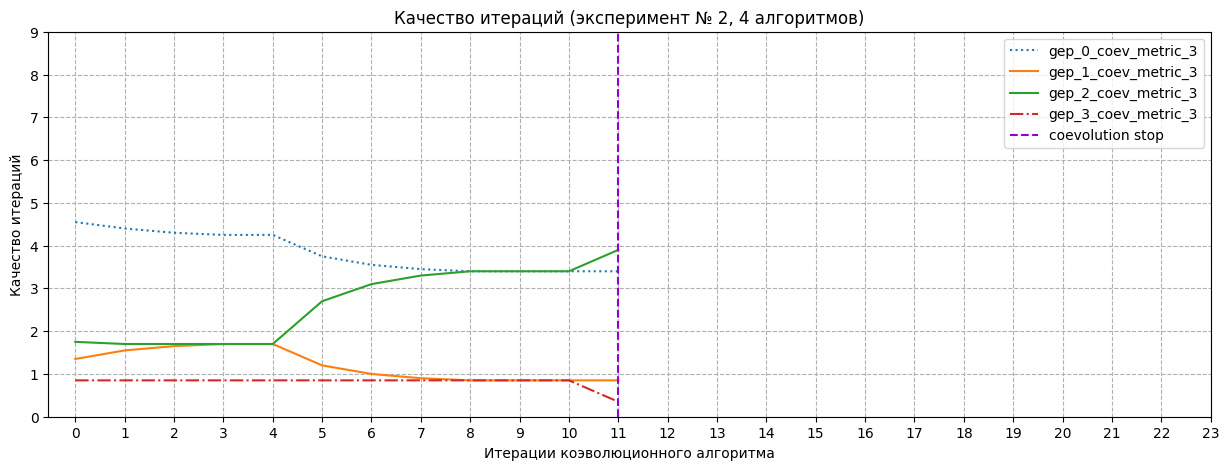

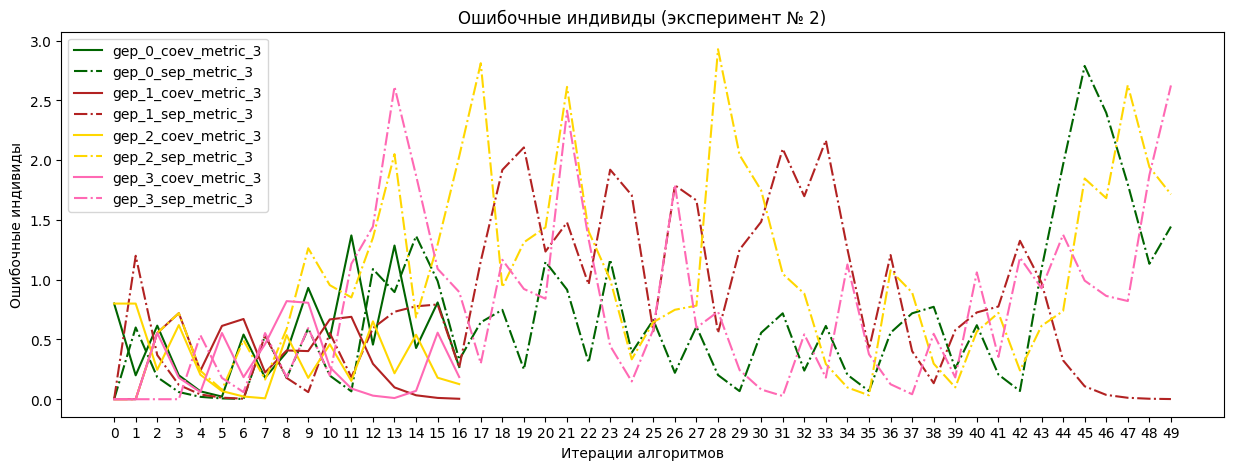


The global minimum is: 44.27240576907071
The global maximum is: 90000000000004.44

Algorithm gep_0_coev_metric_3
	Values best+1%: 0; 0% of population
	Values between best+1% and best+5%: 0; 0% of population
	Values greater than best+5%: 16; 100% of population
Algorithm gep_0_sep_metric_3
	Values best+1%: 12; 24% of population
	Values between best+1% and best+5%: 0; 0% of population
	Values greater than best+5%: 37; 76% of population
Algorithm gep_1_coev_metric_3
	Values best+1%: 0; 0% of population
	Values between best+1% and best+5%: 0; 0% of population
	Values greater than best+5%: 16; 100% of population
Algorithm gep_1_sep_metric_3
	Values best+1%: 32; 65% of population
	Values between best+1% and best+5%: 0; 0% of population
	Values greater than best+5%: 17; 35% of population
Algorithm gep_2_coev_metric_3
	Values best+1%: 0; 0% of population
	Values between best+1% and best+5%: 0; 0% of population
	Values greater than best+5%: 16; 100% of population
Algorithm gep_2_sep_metric_3
	V

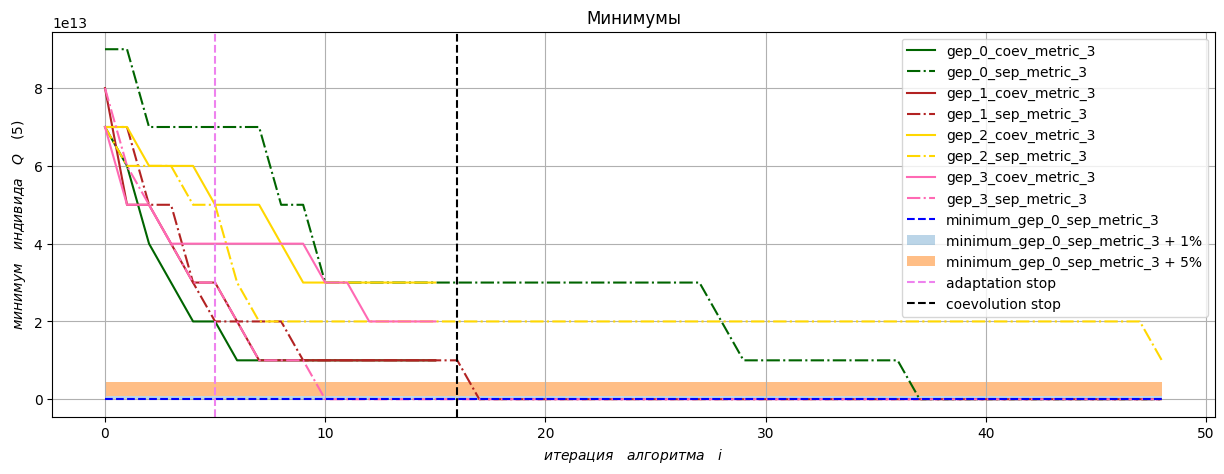

Популярность решений:
--- ('(...)', 8)
--- ('(dcb)', 5)
--- ('(d.b)', 4)
--- ('(a.c)', 3)
--- ('((.).{0,1}.)', 2)
--- ('(..b)', 2)


In [21]:
exp_num = 2
met_num = 3
alg_num = 4

minimum_metrics, qualities_metrics, invalid_metrics, popular_regexes = get_data_from_db(
    num_exp=exp_num, 
    num_metric=met_num
)

get_qualities(
    qualities_metrics, 
    exp_num=exp_num,
    alg_num=alg_num
)

get_invalids(
    invalid_metrics, 
    exp_num=exp_num
)

get_minimums(
    minimum_metrics, 
    adaptation_interval=5
)

get_popular_regexes(
    popular_regexes
)

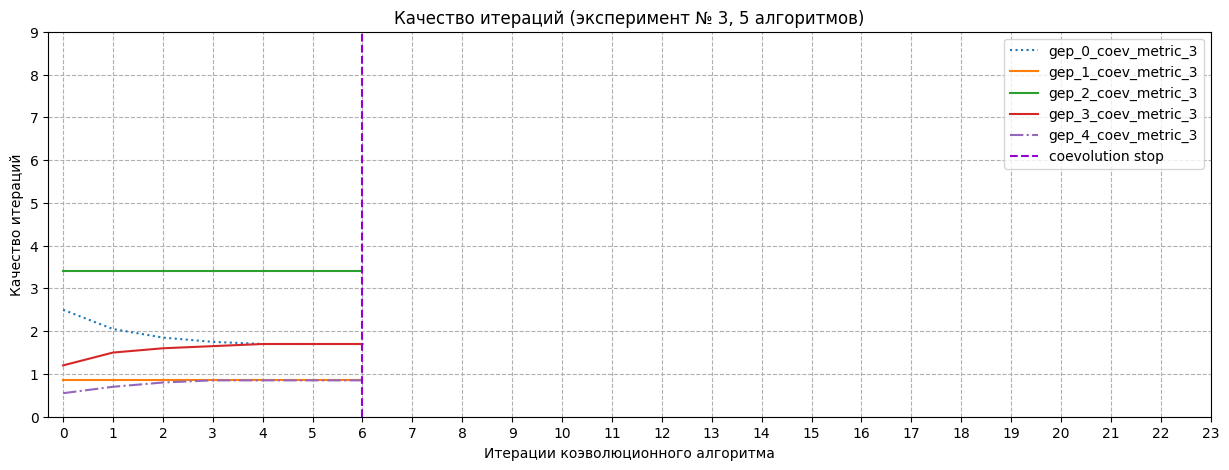

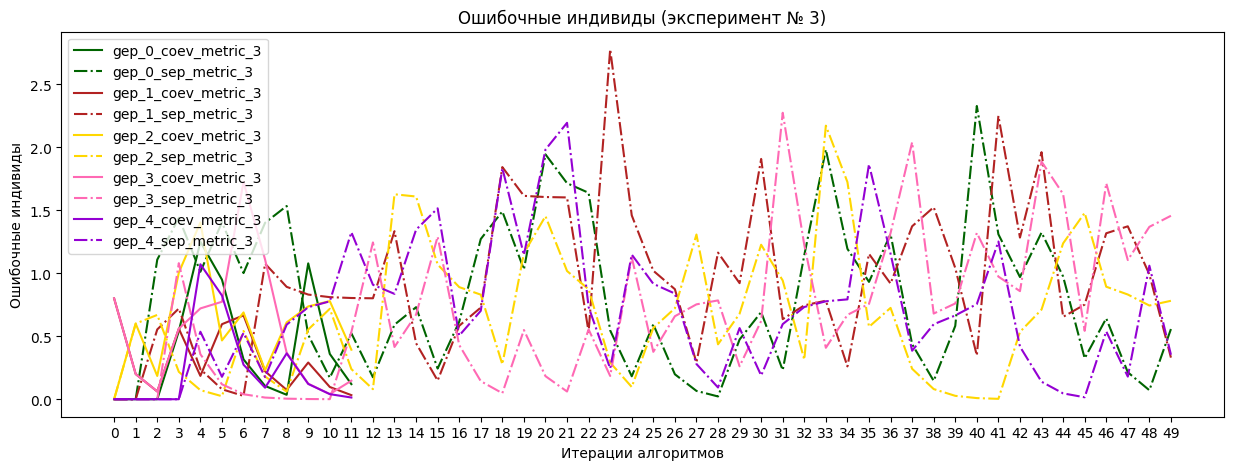


The global minimum is: 43.829747004932976
The global maximum is: 90000000000009.06

Algorithm gep_0_coev_metric_3
	Values best+1%: 0; 0% of population
	Values between best+1% and best+5%: 0; 0% of population
	Values greater than best+5%: 11; 100% of population
Algorithm gep_0_sep_metric_3
	Values best+1%: 42; 86% of population
	Values between best+1% and best+5%: 0; 0% of population
	Values greater than best+5%: 7; 14% of population
Algorithm gep_1_coev_metric_3
	Values best+1%: 0; 0% of population
	Values between best+1% and best+5%: 0; 0% of population
	Values greater than best+5%: 11; 100% of population
Algorithm gep_1_sep_metric_3
	Values best+1%: 38; 78% of population
	Values between best+1% and best+5%: 0; 0% of population
	Values greater than best+5%: 11; 22% of population
Algorithm gep_2_coev_metric_3
	Values best+1%: 0; 0% of population
	Values between best+1% and best+5%: 0; 0% of population
	Values greater than best+5%: 11; 100% of population
Algorithm gep_2_sep_metric_3
	V

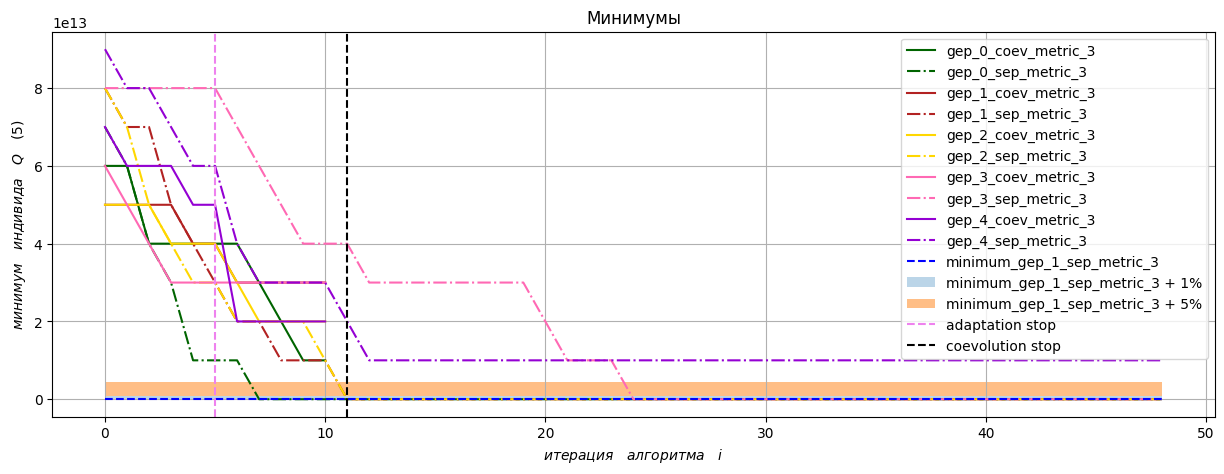

Популярность решений:
--- ('((.).{0,1}.)', 3)
--- ('((.).{0,1}.{0,1})', 3)
--- ('(d..)', 3)
--- ('(...)', 2)
--- ('(..b)', 2)
--- ('(abc)', 2)


In [22]:
exp_num = 3
met_num = 3
alg_num = 5

minimum_metrics, qualities_metrics, invalid_metrics, popular_regexes = get_data_from_db(
    num_exp=exp_num, 
    num_metric=met_num
)

get_qualities(
    qualities_metrics, 
    exp_num=exp_num,
    alg_num=alg_num
)

get_invalids(
    invalid_metrics, 
    exp_num=exp_num
)

get_minimums(
    minimum_metrics, 
    adaptation_interval=5
)

get_popular_regexes(
    popular_regexes
)

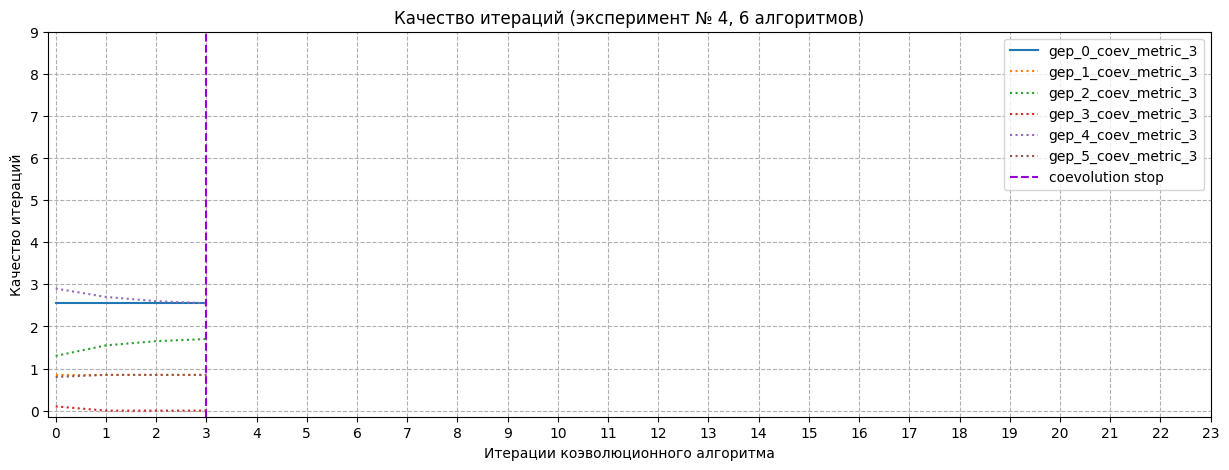

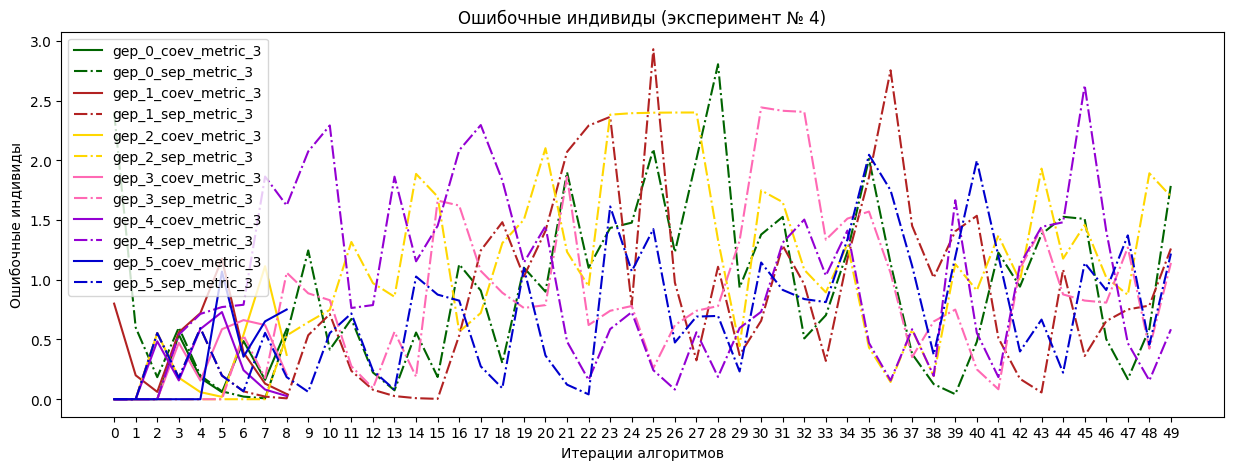


The global minimum is: 45.63444410628538
The global maximum is: 100000000000000.0

Algorithm gep_0_coev_metric_3
	Values best+1%: 0; 0% of population
	Values between best+1% and best+5%: 0; 0% of population
	Values greater than best+5%: 8; 100% of population
Algorithm gep_0_sep_metric_3
	Values best+1%: 27; 55% of population
	Values between best+1% and best+5%: 0; 0% of population
	Values greater than best+5%: 22; 45% of population
Algorithm gep_1_coev_metric_3
	Values best+1%: 0; 0% of population
	Values between best+1% and best+5%: 0; 0% of population
	Values greater than best+5%: 8; 100% of population
Algorithm gep_1_sep_metric_3
	Values best+1%: 22; 45% of population
	Values between best+1% and best+5%: 0; 0% of population
	Values greater than best+5%: 27; 55% of population
Algorithm gep_2_coev_metric_3
	Values best+1%: 0; 0% of population
	Values between best+1% and best+5%: 0; 0% of population
	Values greater than best+5%: 8; 100% of population
Algorithm gep_2_sep_metric_3
	Valu

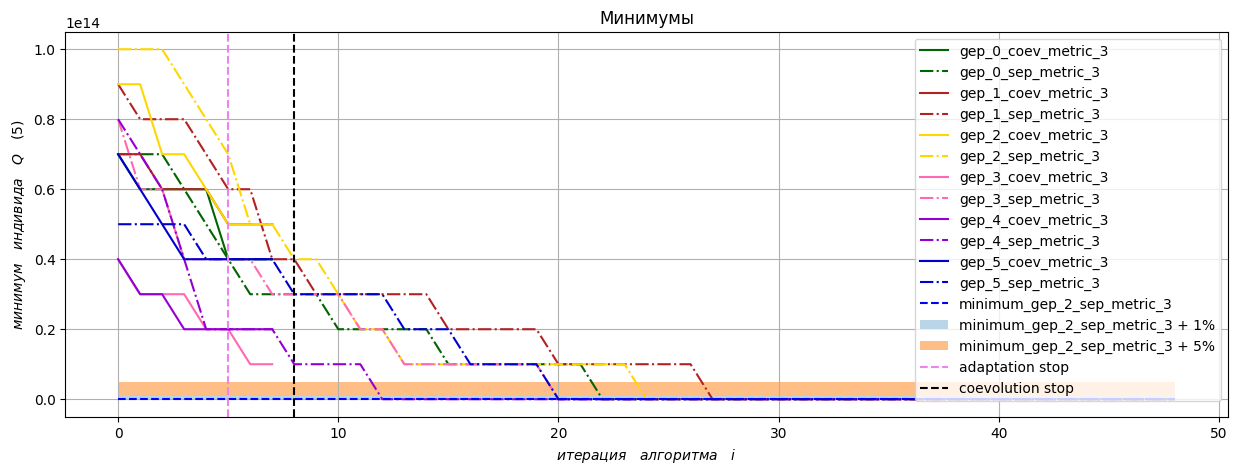

Популярность решений:
--- ('(...)', 6)
--- ('(a.c)', 4)
--- ('(..c)', 3)
--- ('(dc.)', 3)
--- ('(dcb)', 3)
--- ('(.(c|.).)', 2)
--- ('(..(c|b))', 2)
--- ('(.b.)', 2)
--- ('(.cb)', 2)


In [23]:
exp_num = 4
met_num = 3
alg_num = 6

minimum_metrics, qualities_metrics, invalid_metrics, popular_regexes = get_data_from_db(
    num_exp=exp_num, 
    num_metric=met_num
)

get_qualities(
    qualities_metrics, 
    exp_num=exp_num,
    alg_num=alg_num
)

get_invalids(
    invalid_metrics, 
    exp_num=exp_num
)

get_minimums(
    minimum_metrics, 
    adaptation_interval=5
)

get_popular_regexes(
    popular_regexes
)

## Metric №4 - f1-score

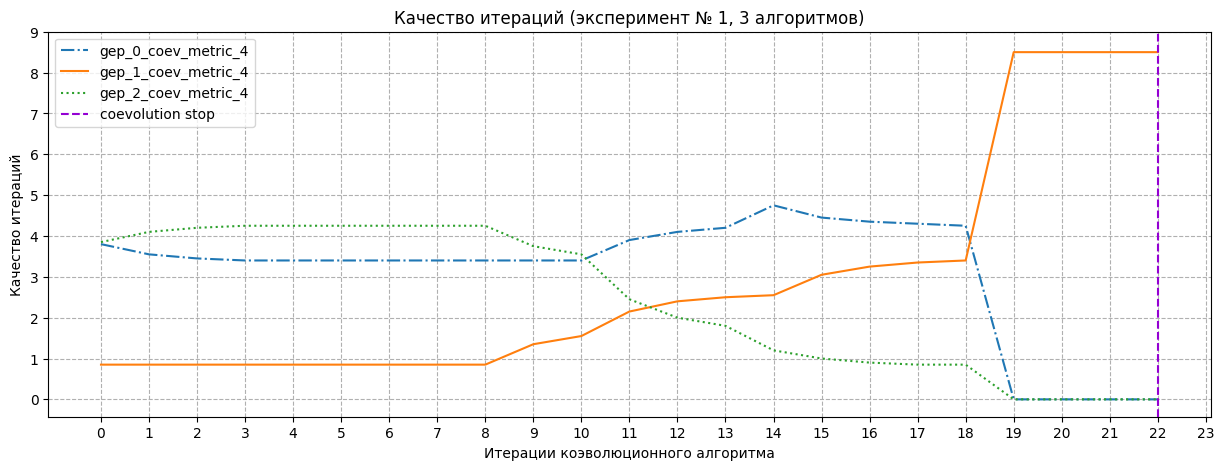

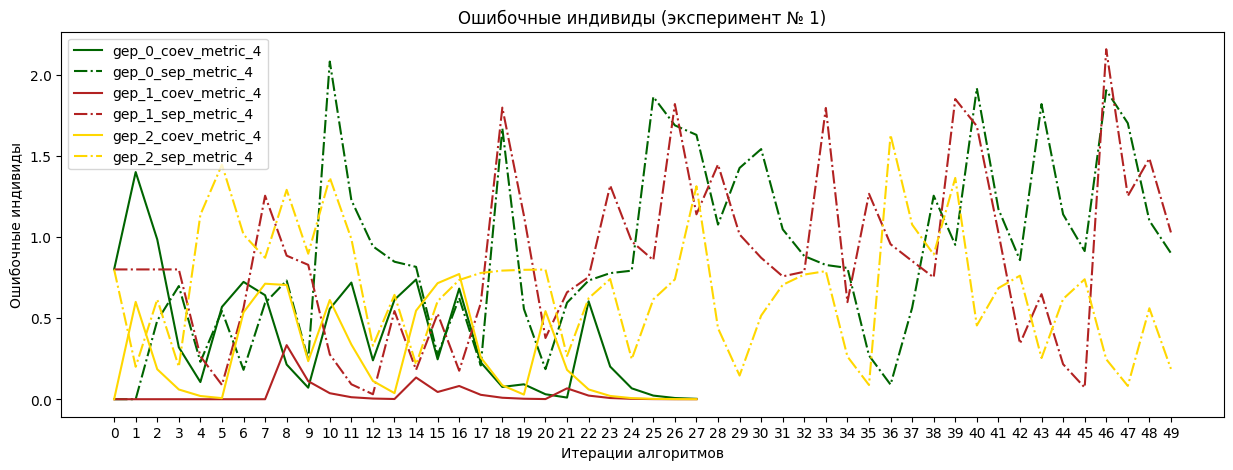


The global minimum is: 25.017670131534185
The global maximum is: 90000000000003.66

Algorithm gep_0_coev_metric_4
	Values best+1%: 4; 15% of population
	Values between best+1% and best+5%: 0; 0% of population
	Values greater than best+5%: 23; 85% of population
Algorithm gep_0_sep_metric_4
	Values best+1%: 36; 73% of population
	Values between best+1% and best+5%: 0; 0% of population
	Values greater than best+5%: 13; 27% of population
Algorithm gep_1_coev_metric_4
	Values best+1%: 4; 15% of population
	Values between best+1% and best+5%: 0; 0% of population
	Values greater than best+5%: 23; 85% of population
Algorithm gep_1_sep_metric_4
	Values best+1%: 9; 18% of population
	Values between best+1% and best+5%: 0; 0% of population
	Values greater than best+5%: 40; 82% of population
Algorithm gep_2_coev_metric_4
	Values best+1%: 4; 15% of population
	Values between best+1% and best+5%: 0; 0% of population
	Values greater than best+5%: 23; 85% of population
Algorithm gep_2_sep_metric_4
	V

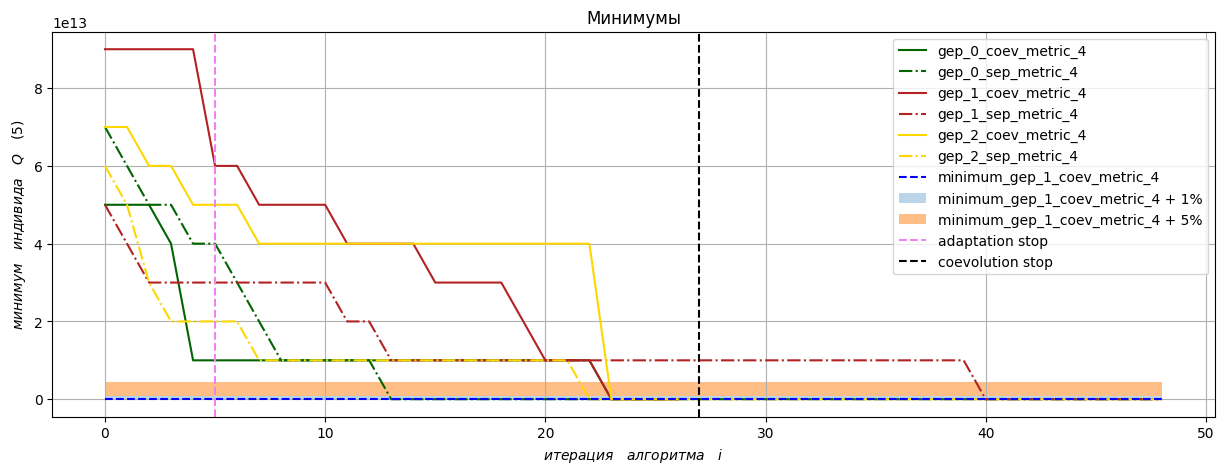

Популярность решений:
--- ('(...)', 3)
--- ('(.c.)', 2)
--- ('(abc)', 2)
--- ('(dc.)', 2)


In [24]:
exp_num = 1
met_num = 4
alg_num = 3

minimum_metrics, qualities_metrics, invalid_metrics, popular_regexes = get_data_from_db(
    num_exp=exp_num, 
    num_metric=met_num
)

get_qualities(
    qualities_metrics, 
    exp_num=exp_num,
    alg_num=alg_num
)

get_invalids(
    invalid_metrics, 
    exp_num=exp_num
)

get_minimums(
    minimum_metrics, 
    adaptation_interval=5
)

get_popular_regexes(
    popular_regexes
)

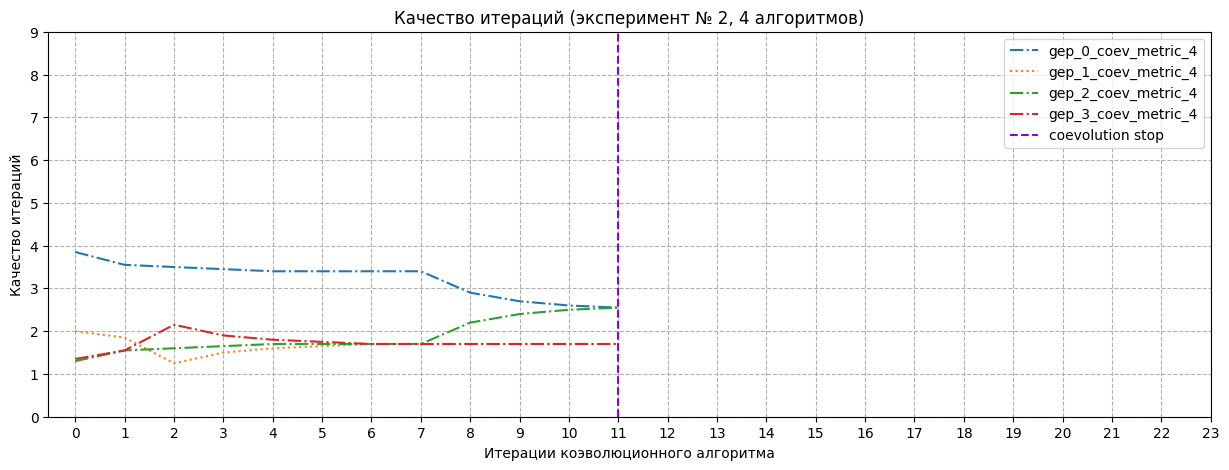

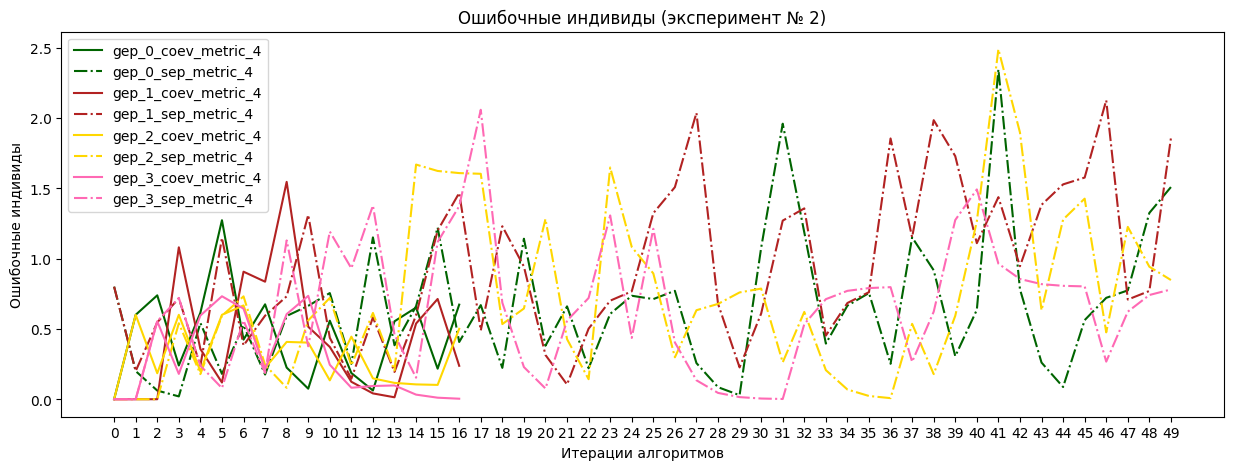


The global minimum is: 30.49429324620764
The global maximum is: 80000000000008.08

Algorithm gep_0_coev_metric_4
	Values best+1%: 0; 0% of population
	Values between best+1% and best+5%: 0; 0% of population
	Values greater than best+5%: 16; 100% of population
Algorithm gep_0_sep_metric_4
	Values best+1%: 34; 69% of population
	Values between best+1% and best+5%: 0; 0% of population
	Values greater than best+5%: 15; 31% of population
Algorithm gep_1_coev_metric_4
	Values best+1%: 0; 0% of population
	Values between best+1% and best+5%: 0; 0% of population
	Values greater than best+5%: 16; 100% of population
Algorithm gep_1_sep_metric_4
	Values best+1%: 33; 67% of population
	Values between best+1% and best+5%: 0; 0% of population
	Values greater than best+5%: 16; 33% of population
Algorithm gep_2_coev_metric_4
	Values best+1%: 8; 50% of population
	Values between best+1% and best+5%: 0; 0% of population
	Values greater than best+5%: 8; 50% of population
Algorithm gep_2_sep_metric_4
	Va

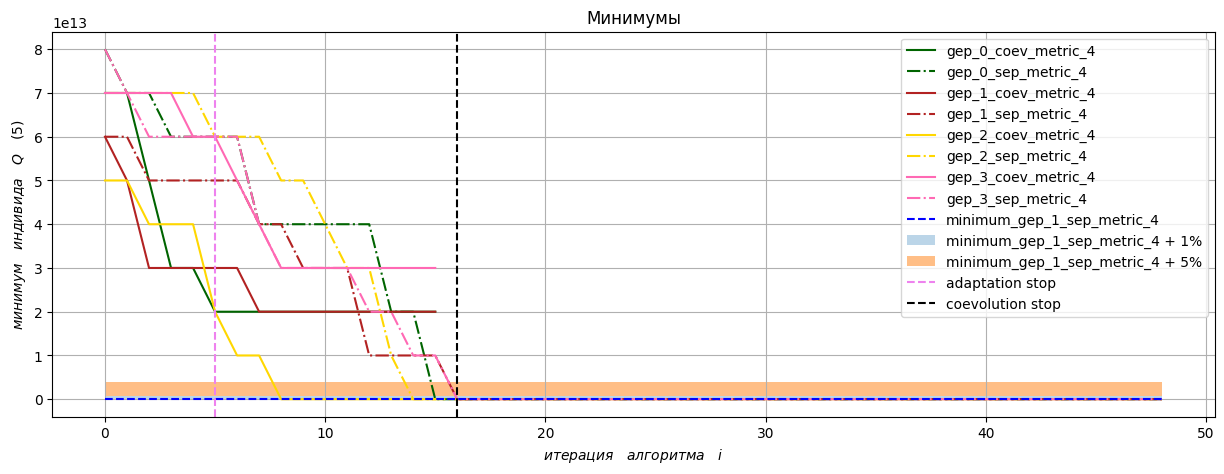

Популярность решений:
--- ('(...)', 5)
--- ('(.c.)', 3)
--- ('(ab.)', 3)
--- ('(d..)', 2)
--- ('(d.b)', 2)


In [25]:
exp_num = 2
met_num = 4
alg_num = 4

minimum_metrics, qualities_metrics, invalid_metrics, popular_regexes = get_data_from_db(
    num_exp=exp_num, 
    num_metric=met_num
)

get_qualities(
    qualities_metrics, 
    exp_num=exp_num,
    alg_num=alg_num
)

get_invalids(
    invalid_metrics, 
    exp_num=exp_num
)

get_minimums(
    minimum_metrics, 
    adaptation_interval=5
)

get_popular_regexes(
    popular_regexes
)

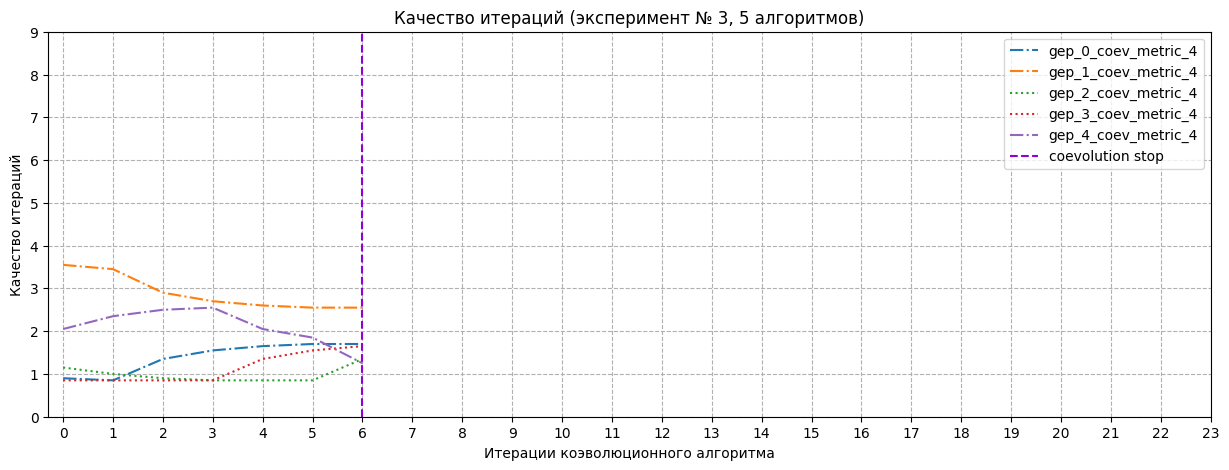

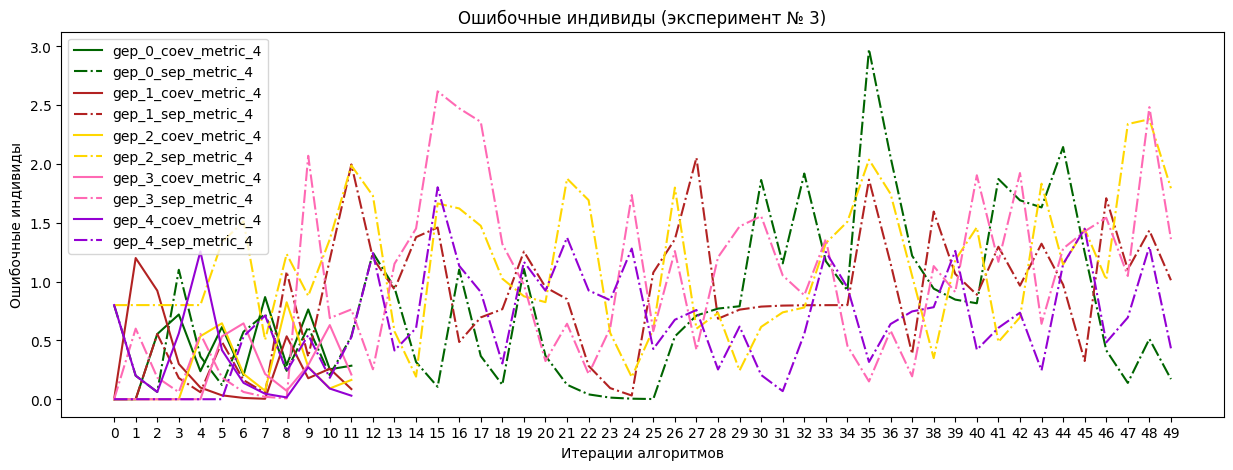


The global minimum is: 30.024283564153365
The global maximum is: 90000000000004.67

Algorithm gep_0_coev_metric_4
	Values best+1%: 0; 0% of population
	Values between best+1% and best+5%: 0; 0% of population
	Values greater than best+5%: 11; 100% of population
Algorithm gep_0_sep_metric_4
	Values best+1%: 17; 35% of population
	Values between best+1% and best+5%: 0; 0% of population
	Values greater than best+5%: 32; 65% of population
Algorithm gep_1_coev_metric_4
	Values best+1%: 0; 0% of population
	Values between best+1% and best+5%: 0; 0% of population
	Values greater than best+5%: 11; 100% of population
Algorithm gep_1_sep_metric_4
	Values best+1%: 26; 53% of population
	Values between best+1% and best+5%: 0; 0% of population
	Values greater than best+5%: 23; 47% of population
Algorithm gep_2_coev_metric_4
	Values best+1%: 0; 0% of population
	Values between best+1% and best+5%: 0; 0% of population
	Values greater than best+5%: 11; 100% of population
Algorithm gep_2_sep_metric_4
	

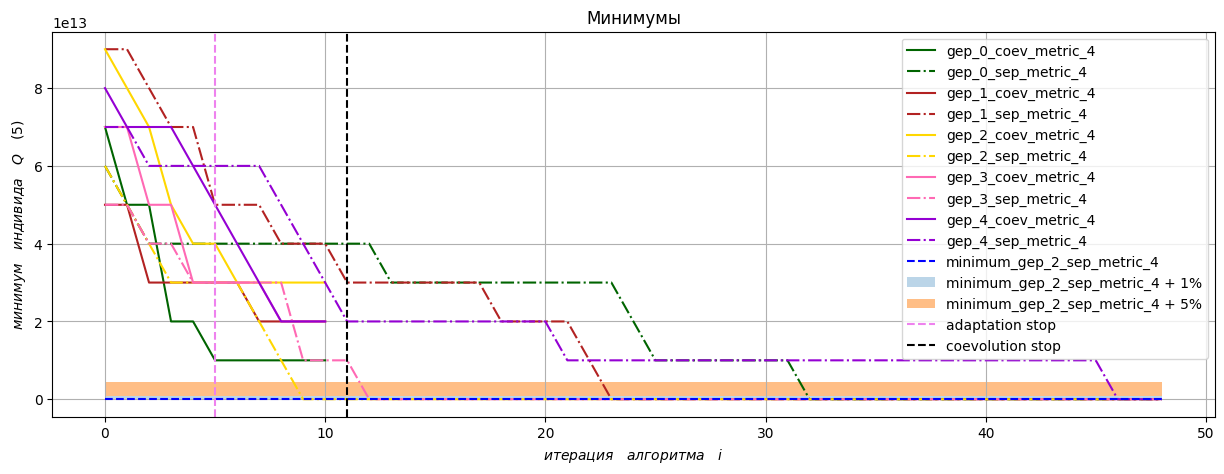

Популярность решений:
--- ('(...)', 4)
--- ('(d.b)', 4)
--- ('((.)..{0,1})', 2)
--- ('(([0-9]|.)..)', 2)
--- ('(.(.).{0,1})', 2)
--- ('(..b)', 2)
--- ('(abc)', 2)
--- ('(dcb)', 2)


In [26]:
exp_num = 3
met_num = 4
alg_num = 5

minimum_metrics, qualities_metrics, invalid_metrics, popular_regexes = get_data_from_db(
    num_exp=exp_num, 
    num_metric=met_num
)

get_qualities(
    qualities_metrics, 
    exp_num=exp_num,
    alg_num=alg_num
)

get_invalids(
    invalid_metrics, 
    exp_num=exp_num
)

get_minimums(
    minimum_metrics, 
    adaptation_interval=5
)

get_popular_regexes(
    popular_regexes
)

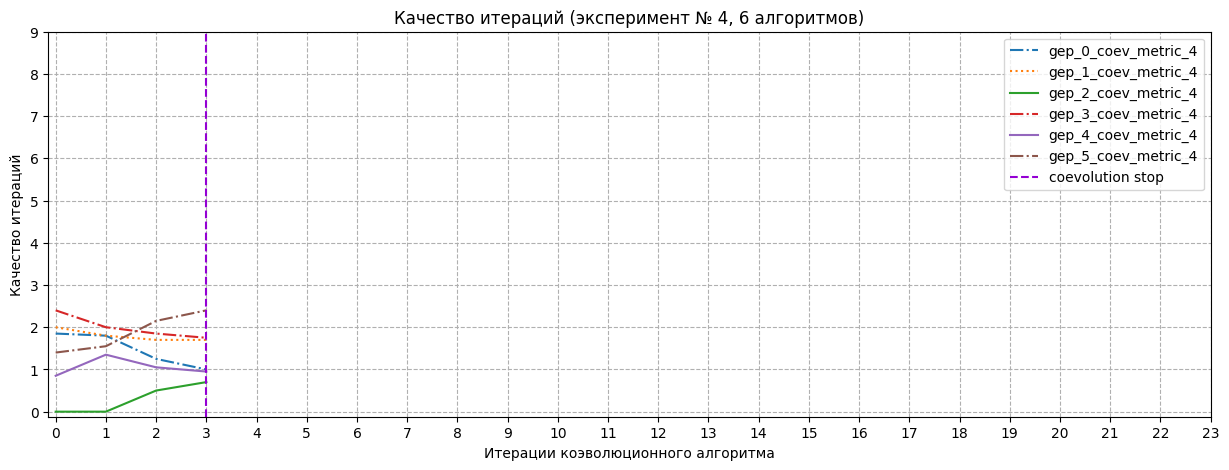

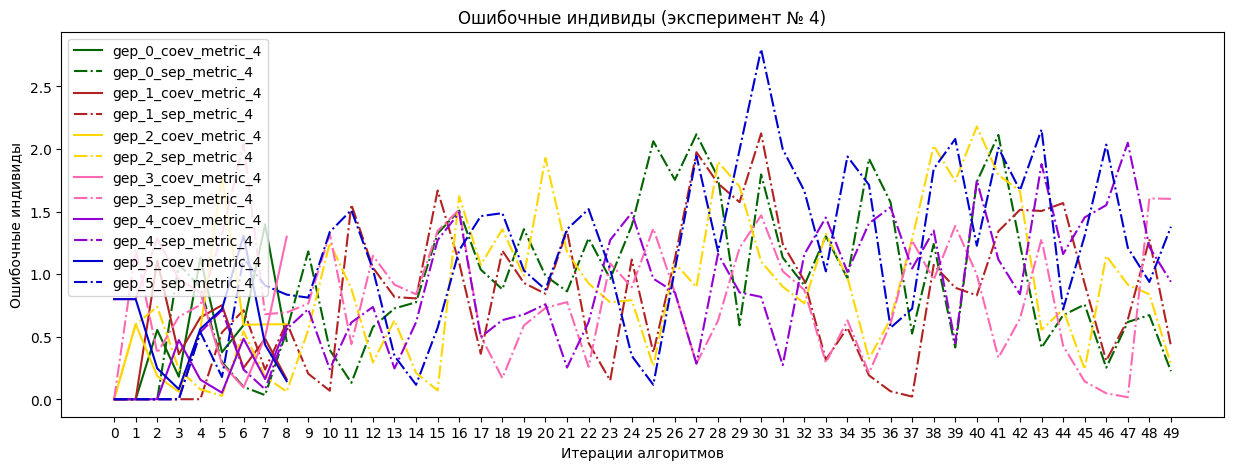


The global minimum is: 28.873588552785
The global maximum is: 70000000000015.09

Algorithm gep_0_coev_metric_4
	Values best+1%: 0; 0% of population
	Values between best+1% and best+5%: 0; 0% of population
	Values greater than best+5%: 8; 100% of population
Algorithm gep_0_sep_metric_4
	Values best+1%: 27; 55% of population
	Values between best+1% and best+5%: 0; 0% of population
	Values greater than best+5%: 22; 45% of population
Algorithm gep_1_coev_metric_4
	Values best+1%: 0; 0% of population
	Values between best+1% and best+5%: 0; 0% of population
	Values greater than best+5%: 8; 100% of population
Algorithm gep_1_sep_metric_4
	Values best+1%: 30; 61% of population
	Values between best+1% and best+5%: 0; 0% of population
	Values greater than best+5%: 19; 39% of population
Algorithm gep_2_coev_metric_4
	Values best+1%: 0; 0% of population
	Values between best+1% and best+5%: 0; 0% of population
	Values greater than best+5%: 8; 100% of population
Algorithm gep_2_sep_metric_4
	Values

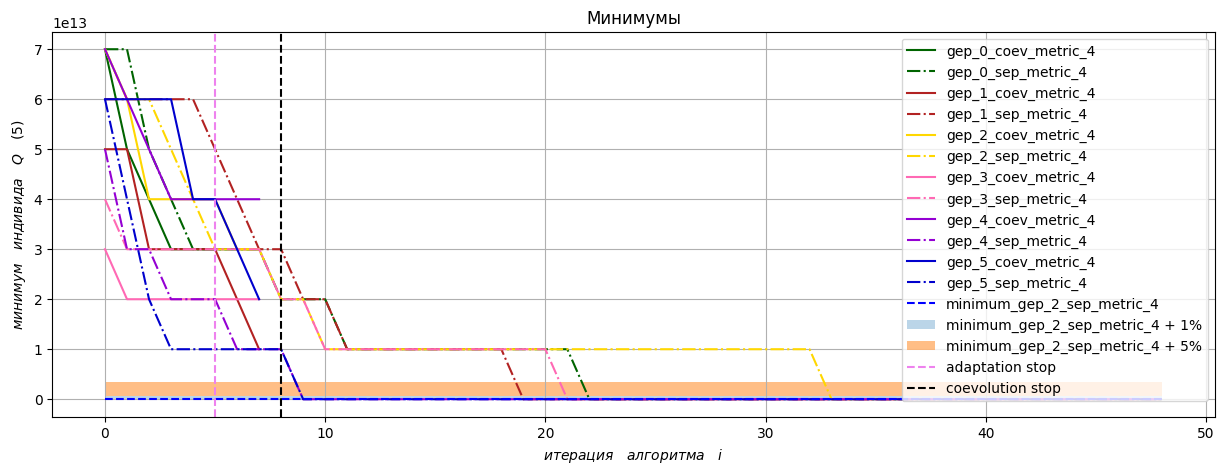

Популярность решений:
--- ('(...)', 7)
--- ('(dcb)', 7)
--- ('(d..)', 3)
--- ('((.).{0,1}.)', 2)
--- ('((.|a)..)', 2)
--- ('(.cb)', 2)
--- ('(a.c)', 2)
--- ('(d.b)', 2)
--- ('(dc.)', 2)


In [27]:
exp_num = 4
met_num = 4
alg_num = 6

minimum_metrics, qualities_metrics, invalid_metrics, popular_regexes = get_data_from_db(
    num_exp=exp_num, 
    num_metric=met_num
)

get_qualities(
    qualities_metrics, 
    exp_num=exp_num,
    alg_num=alg_num
)

get_invalids(
    invalid_metrics, 
    exp_num=exp_num
)

get_minimums(
    minimum_metrics, 
    adaptation_interval=5
)

get_popular_regexes(
    popular_regexes
)